<a href="https://colab.research.google.com/github/juandmantilla/Deteccion-de-accidentes-automovilisticos/blob/master/Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXPERIMENTOS AUTOMATIZADOS

En este notebook se tratará de automatizar los procesos para la evaluación de los algoritmos de RF, SVR ARIMA y LSTM.


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- Carga de Modelos ----------------------
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA
from sklearn.svm import SVR
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential

# ----------------------------- Carga de herramientas -----------------
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

# ----------------------------------------------------------------------




# Función que retorna un dataframe según las condiciones de nodeId y SrcNode
def cargarDatos(direccion, nodeId, SrcNode):
    df = pd.read_csv(direccion)
    df = df.loc[df['NodeId'] == nodeId]
    df = df.loc[df['SrcNodeId'] == SrcNode ]
    return df


# Función que realiza la diferencia entre una observación en el tiempo t con respecto a
# otra en el tiempo t-1. Los valores que corresponden a cero serán cambiados a 0.5 para
# evitar posibles indeterminaciones en el cálculo de erroes. 
def diferenciarSerie(datos, indicador):
    a = datos[[indicador]].diff(periods = 1).values
    a[0] = a[1]
    fecha = datos[["Date"]].values
    
    b = np.concatenate((fecha, a), axis = 1)
    
    datos = pd.DataFrame(data = b, columns=["Date", indicador])
    
    # Cambio de valores con 0 para evitar indeterminaciones
    datos.loc[datos[indicador] == 0, indicador] = 0.5
    return datos
  

# Función que genera una serie de tiempo de promedios móviles. La ventana móvil
# indicada es de 5 observaciones temporales.
def promediarSerie(datos, indicador):
    datos = datos.rolling(5).mean()
    datos[indicador].fillna(0.5, inplace = True)
    print(datos)
    return datos
    

# Función que genera 2 subconjuntos de datos. 
# * dataX corresponde a las observaciones X_t = Y_t-1
# * dataY corresponde a las observaciones en el tiempo t
def unPaso(datos, indicador):    
    dataX = np.array([])
    dataY = np.array([])
    
    for i in range(len(datos.values)):
        dataX = np.append(dataX, datos[[indicador]].values[i-1])
        dataY = np.append(dataY, datos[[indicador]].values[i])
    
    dataX[0] = 0
    
    return dataX, dataY


# Función que genera 2 subconjuntos de datos.
# * dataTransform[:, :-1] es una arreglo bidimensional que contiene los  t-n observaciones anteriores a t.
# * dataTransform[:, -1] es un arreglo unidimensional que contiene las observaciones en un tiempo t.
# Este algoritmo es basado en el recurso en línea: 
# https://stackoverflow.com/questions/48967169/time-delay-embedding-of-time-series-in-python
def multiplesPasos(datos, indicador, pasos):
    a = np.array([])
    for i in datos[[indicador]].values:
        a = np.append(a, i[0])
  
      # Se implementa el Time Delay Embedding. Que es una ténica para obtener los valores t - n hacia atrás de un
      # valor LQI en el tiempo t. Esta función recibe el parámetro w que indica la cantidad de pasos hacia atrás que se
      # tendrán en cuenta y el parámetro g define la cantidad de pasos para una observación en un tiempo t + g


    w = pasos + 1  #----> Cantidad de observaciones que se tienen en cuenta para definir la observación en tiempo t más uno

    g = 1  # ---> Si una observación está en el tiempo t, esta define la siguiente observación en tiempo t + g

    dataTransform = a[(np.arange(w)*(g))+ np.arange(np.max(a.shape[0] - (w-1)*(g), 0)).reshape(-1,1)]
    dataTransform = np.array(dataTransform)
    
    
    return dataTransform[:, :-1], dataTransform[:, -1]




#---------------------------------------------DEFINICIÓN DE MODELOS ------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------


# Función modeloRF realiza pretratamiento de datos genera; conjuntos de entrenamiento y prueba,
# el modelo de Random Forest Regressor, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de entrenamiento, prueba y regresiones (renombrado como predicciones).
# Este algoritmo es basado en el recurso en línea: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest#sklearn.ensemble.RandomForestRegressor
def modeloRF(dataX, dataY, pasos, diferenciada, datosOriginales, indicador):

  # Generando el conjunto de datos. 80% de entrenamiento. Recuerde que shuffle indica que los valores
  # no se muevan aleatoriamente en el conjunto de datos
  fc = 0
  x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

  random = RandomForestRegressor(n_estimators=150, oob_score= True)
    
  pred = 0
    
  # Con 1 paso y no diferenciada
  if(pasos == 1 and diferenciada == False):
    random = random.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = random.predict(x_test.reshape(-1, 1))
        
  # Con pasos y no diferenciada
  elif(pasos > 1 and diferenciada == False):
    random = random.fit(x_train, y_train)
    pred = random.predict(x_test)
        
        
  # Con 1 paso y diferenciada
  elif(pasos == 1 and diferenciada == True):

    fc = x_train.shape[0]
    random = random.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = random.predict(x_test.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc + i]
      b = np.append(b, a) 
        
    pred = b

    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]
    
  # Con pasos y diferenciada
  elif((pasos > 1) and diferenciada == True):
  # Suma de numeros de filas y columnas para el desplazamiento
    fc = x_train.shape[0] + x_train.shape[1]
        
    random = random.fit(x_train, y_train)
    pred = random.predict(x_test)
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i ]
      b = np.append(b, a) 
        
    pred = b
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

  return y_test, pred, y_train



# Función modeloSVM realiza pretratamiento de datos y genera; conjuntos de entrenamiento y prueba,
# modelo de Support Vector Regressor, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de entrenamiento, prueba y regresiones (renombrado como predicciones).
# Este algoritmo es basado en el recurso en línea: 
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR
def modeloSVM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador):
  x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4, shuffle= False)
  svr = SVR()
  pred = 0
  fc = 0
  # Con 1 paso y no diferenciada
  if(pasos == 1 and diferenciada == False):
    svr = svr.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = svr.predict(x_test.reshape(-1, 1))
        
  # Con pasos y no diferenciada
  elif(pasos > 1 and diferenciada == False):
    svr = svr.fit(x_train, y_train)
    pred = svr.predict(x_test)
        
  # Con 1 paso y diferenciada
  elif(pasos == 1 and diferenciada == True):

    fc = x_train.shape[0]

    svr = svr.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = svr.predict(x_test.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):  
      a = pred[i] + datosOriginales[indicador].values[fc + i]
      b = np.append(b, a) 

    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]
    
  # Con pasos y diferenciada
  elif(pasos > 1 and diferenciada == True):
    fc = x_train.shape[0] +x_train.shape[1]
    svr = svr.fit(x_train, y_train)
    pred = svr.predict(x_test)
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i ]
      b = np.append(b, a) 
        
    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

  return y_test, pred, y_train


# Función modeloARIMA realiza pretratamiento de datos y genera; conjuntos de entrenamiento y prueba,
# modelo de ARIMA, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de prueba, regresiones (renombrado como predicciones)

# Este algoritmo es basado en el recurso en línea: 
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def modeloArima(datos, pasosTemp ,pasosDif ,indicador):
    
    datos = datos[[indicador]].values
    datos = datos.astype("float32")
    
    # Creando conjunto de entrenamiento y prueba
    num = int(len(datos)*0.6)

    entrenamiento, prueba = datos[:num], datos[num:]

    # Como por cada observación y posterior proyección se debe analizar observaciones anteriores, entonces se debe
    # entrenar el modelo para cada observacion proyectada

    #Copia de entrenamiento. Ese arreglo guarda valores nuevos del arreglo de prueba.
    #Para garantizar que el modelo ARIMA se entrene con los valores posteriores a las observaciones de entrenamiento
    h = [i for i in entrenamiento]

    predicciones = []

    #Por cada observación de prueba se genera la proyección con respecto a las observaciones de test
    for i in range(len(prueba)):

        # --> Recuerde los parámetros de ARIMA.
        modeloArima = ARIMA(h, order=(pasosTemp, pasosDif, 0))
        modeloEntrenado = modeloArima.fit(disp = 0)

        # Predicción de observación para la observación t+1 de entrenamiento
        salida = modeloEntrenado.forecast()

        predTime = salida[0]
        predicciones.append(predTime)

        #Obteniendo valor real de la observación en tiempo t+1
        obs = prueba[i]

        #Añadiendo al vector para que se entrene nuevamente con este valor en la siguiente iteración.
        h.append(obs)

    return prueba, predicciones, num


# Función para arreglos unidimensionales. Función para transformar el dominio
# de los datos. Retorna datos escalados con su respectivo escalador (scaler).
# Este algoritmo es basado en el recurso en línea: 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
def cambiarEscala(dataX, dataY, pasos):
  if(pasos == 1):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(dataX.reshape(-1, 1))

    dataX = dataX.reshape(-1, 1)
    dataX = scaler.transform(dataX)

    dataY = dataY.reshape(-1, 1)
    dataY = scaler.transform(dataY)
    
    scaler2 = 0

  elif(pasos > 1):

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(dataX)

    scaler2 = MinMaxScaler(feature_range=(-1, 1))
    scaler2 = scaler2.fit(dataY.reshape(-1, 1))

    dataX = scaler.transform(dataX)
    dataY = scaler2.transform(dataY.reshape(-1, 1))

  return dataX, dataY, scaler, scaler2


# Función de inversión de escala de datos, retorna datos en el dominio original 
def invertirEscala(scaler, datos):
    datos = scaler.inverse_transform(datos)
    return datos


# -------------------------------------- MODELO LSTM  ----------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------


# Función modeloSVM realiza pretratamiento de datos y genera; conjuntos de entrenamiento y prueba,
# modelo de Support Vector Regressor, realiza regresiones en los conjuntos de datos
# generados y retorna arreglos de entrenamiento, prueba y regresiones (renombrado como predicciones).
def modeloLSTM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador,
              numNeuronas, batch_size, numEpoc):
  fc = 0
  pred = np.array([])
  y_test = np.array([])

  # 1 pasos sin diferenciar ----------------------------------------------------
  if ((pasos == 1) and diferenciada == False):

    # Generando el conjunto de datos. 60% de entrenamiento. Recuerde que shuffle indica que los valores
    # no se muevan aleatoriamente en el conjunto de datos
    dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4, shuffle= False)

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        
    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    y_train = invertirEscala(scaler, y_train)
    pred = invertirEscala(scaler, testPredict) 
    y_test = invertirEscala(scaler, y_test)

    # Preparar datos de entrenamiento y prueba para más pasos.

  # Pasos sin diferenciar ----------------------------------------------------------------------------
  elif ((pasos > 1) and diferenciada == False):
    dataX, dataY, scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    y_train = invertirEscala(scaler2, y_train)
    pred = invertirEscala(scaler2, testPredict)
    y_test = invertirEscala(scaler2, y_test)
    

  # 1 paso y diferenciada ---------------------------------------------------------------------------
  elif ((pasos == 1) and diferenciada == True):
    dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

    fc = x_train.shape[0]
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        
    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    #y_train = invertirEscala(scaler, y_train)
    pred = invertirEscala(scaler, testPredict)
    #y_test = invertirEscala(scaler, y_test)

    
    #Transformar datos para el dominio original
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i ]
      b = np.append(b, a) 
        
    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

  # Pasos y diferenciada --------------------------------------------------------------------
  elif ((pasos > 1) and diferenciada == True):

    dataX, dataY, scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

    fc = x_train.shape[0] + x_train.shape[1] 

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

   

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    #y_train = invertirEscala(scaler2, y_train)
    pred = invertirEscala(scaler2, testPredict)
    #y_test = invertirEscala(scaler2, y_test)
    
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc + i ]
      b = np.append(b, a) 
        
    pred = b    
    y_train = datosOriginales[indicador].values[ : fc]
    y_test = datosOriginales[indicador].values[fc : ]
    pred = pred[:y_test.shape[0]]

  return y_test, pred, y_train



#---------------------------------------ERRORES---------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------


# Función errores retorna los diferentes métricas de error con respecto
# a los datos de prueba y las predicciones.
def errores(y_test, pred):

  # Función mean_absolute_percentage_error es basado en el recurso en línea:
  # https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
  def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


  MSE =  round(mean_squared_error( y_test.reshape(-1, 1) , pred), 5)
  MAPE = round( mean_absolute_percentage_error(y_test.reshape(-1, 1), pred) , 5)
  MAE =  round( median_absolute_error(y_test.reshape(-1, 1), pred), 5)
  r2 =   round(r2_score(y_test.reshape(-1, 1), pred), 5)

  return MSE, MAE, MAPE, r2 


  
#-----------------------------------------MOSTRAR SERIE-------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------

# Función que grafica la serie temporal predicha
def mostrarSerie(datosOriginales,  y_train, pred, indicador, modelo, pasos, diferencia):
  
  plt.plot(datosOriginales[["Date"]][ y_train.shape[0]: y_train.shape[0] + pred.shape[0] ], pred, label = modelo )

    
# Función que grafica la serie temporal predicha realizada por el modelo ARIMA
def mostrarSerieARIMA(datosOriginales, pred, num, indicador, modelo):
  plt.plot(datosOriginales[["Date"]][num:], pred, label = modelo)
  

# Función que asigna los títulos, etiquetas y demás a la gráfica de la serie temporal
def labelSerie(datosOriginales, indicador, pasos):
  #Imprimir serie temporal real
  plt.plot(datosOriginales[["Date"]], datosOriginales[[indicador]].values, color="black", label = "Original")
  plt.legend()

  num = int (len(datosOriginales[[indicador]])*0.55)
  array = [datosOriginales[["Date"]].values[num], datosOriginales[["Date"]].values[-1]]
  plt.xlim(array)
  #plt.ylim([-20, 0])

  #Título y subtítulo del gráfico
  plt.title("Node " + str(nodeId) + " - " + str(SrcNode) )
  plt.suptitle("Timestep : " + str(pasos))
    

#-----------------------------------------DIAGRAMAS DE CAJAS-----------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

def cajasBigotes(RF, SVM, ARIMA, LSTM):
  RF = np.array(RF).ravel()
  SVM = np.array(SVM).ravel()
  ARIMA = np.array(ARIMA).ravel()
  LSTM = np.array(LSTM).ravel()
  plt.boxplot((RF, SVM, ARIMA, LSTM), sym="o", labels=["RF", "SVM", "ARIMA", "LSTM"])



#----------------------------------------- PRUEBA DE AUTOCORRELACIÓN---------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

# Función que grafica la serie temporal correlacionada consigo misma.
# Este algoritmo está basado en el recurso en línea : 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html

def correlacionarSerie(datos):
  autocorrelation_plot(datos)



## **Prueba Dickey-Fuller**

La prueba de Dickey-Fuller aumentada puede utilizarse para **comprobar la raíz unitaria** en un proceso univariado en presencia de una correlación en serie.

---
**Hipótesis nula (H0):** Si no se rechaza, sugiere que la serie de tiempo tiene una raíz unitaria, lo que significa que **no es estacionaria**. Tiene una estructura dependiente del tiempo.
    
**Hipótesis Alternativa (H1):** La hipótesis nula es rechazada; sugiere que la serie de tiempo no tiene una raíz unitaria, lo que significa que **es estacionaria** . No tiene una estructura dependiente del tiempo.

---

Valor ***p > 0,05:*** Si no se rechaza la hipótesis nula (H0), los datos tienen una raíz unitaria y no son estacionarios.
  
Valor ***p <= 0,05:*** Rechazar la hipótesis nula (H0), el dato no tiene una raíz unitaria y es estacionario.

In [22]:
# Este algoritmo está basado en los recursos en línea : https://machinelearningmastery.com/time-series-data-stationary-python/ y en
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

def pruebaDickeyFuller(datos):
  resultado = adfuller(datos)
  print("ADF Estadistico: %f" % resultado[0])
  print("Valor p: %f" % resultado[1])
  print("Valores críticos")
  for key, value in resultado[4].items():
      print('\t%s: %.3f' % (key, value))

# **FUNCIÓN EJECUTAR MODELOS**

In [23]:
#Parámetro diferencia hace referencia a un booleano para indicar si la serie que se usa es diferenciada
# dataX, dataY, pasos, diferenciada, datosOriginales, indicador
a = 0
def ejecutarModelos(diferencia, promediada, path, nodeId, SrcNode, indicador, numNeuronas, epocas ):
    
    #Guarda en variable los datos cargados. Evitar cargar varias veces.
    datos = cargarDatos(path, nodeId, SrcNode)
    
    
    #Diccionarios que guardan los errores de los modelos
    dicRF = {}
    dicSVM = {}
    dicARIMA = {}
    dicLSTM = {}

    #--------------- PRUEBA DE AUTOCORRELACIÓN---------------------------------

    # Resultados de la prueba de Dickey-Fuller a la serie temporal original
    
    serie = datos.values[:, -1]

    pruebaDickeyFuller(serie)

    #--------------------------------------------------------------------------


    if (diferencia == False and promediada == False ):
        print ("----------------------- SIN DIFERENCIAS ---------------------")
        
        for i in range(1,5):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = unPaso(datos, indicador)    #----> Sólo para RF Y SVM
                
                #Creación de objeto plt
                plt.figure(figsize=(15, 5))
                                
                RF =  modeloRF(datosML[0], datosML[1], i, False, datos, indicador)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                
                
                SVM = modeloSVM(datosML[0], datosML[1], i, False, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                
                                
                ARIMA = modeloArima(datos, i, 0, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")
                
                                
               # modeloLSTM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador,numNeuronas, batch_size, epochs):
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, False, datos, indicador, numNeuronas, 1, epocas) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia) 
                
                
                #labelSerie imprime el títulos, label y timestap
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])


                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                                                
            elif(i>1):

                #Ejecutar modelos para más pasos históricos
                datosML = multiplesPasos(datos, indicador, i)    #----> Sólo para RF Y SVM
                
                plt.figure(figsize=(15, 5))

                RF =  modeloRF(datosML[0], datosML[1], i, False, datos, indicador)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                

                SVM = modeloSVM(datosML[0], datosML[1], i, False, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                

                ARIMA = modeloArima(datos, i, 0, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA" )
                
                                
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, False, datos, indicador, numNeuronas, 1, epocas) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])
                
                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1]) 
                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM
                

        return dicRF, dicSVM, dicARIMA, dicLSTM
    
    elif (diferencia == True and promediada == False):
        
        print ("-----------------------  SERIE DE DIFERENCIAS -----------------")
        
        for i in range(1,5):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = diferenciarSerie(datos, indicador)
                datosML = unPaso(datosML, indicador)    #----> Para RF, SVM Y LSTM

                plt.figure(figsize=(15, 5))
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador)

                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                plt.legend("RF")

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                plt.legend("SVM")

                ARIMA = modeloArima(datos, i, 1, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")
                
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1]) 

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

            elif(i>1):
                
                datosML = diferenciarSerie(datos, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datos, i, 1, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador , "ARIMA")
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                


        return dicRF, dicSVM, dicARIMA, dicLSTM
        
    elif(diferencia == True and promediada == True):
        
        print ("---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------")
        
        for i in range(1,5):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = diferenciarSerie(datos, indicador)
                datosML = promediarSerie(datosML, indicador)
                datosML = unPaso(datosML, indicador) 

                #datos promediados para ARIMA
                datosProm = promediarSerie(datos, indicador)

                plt.figure(figsize=(15, 5))

                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datosProm, i, 1, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")

                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia) 
                
                labelSerie(datos, indicador, i)
                
                #Diagramas de cajas
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])
                
                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

            elif(i>1):

                datosML = diferenciarSerie(datos, indicador)
                datosML = promediarSerie (datosML, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datos, i, 1, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador , "ARIMA")
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Diagramas de cajas
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVR :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

    
        return dicRF, dicSVM, dicARIMA, dicLSTM

# **EJECUCIÓN MODELOS**






# **Distribución Original**

**Valores LQI**


ADF Estadistico: -12.576093
Valor p: 0.000000
Valores críticos
	1%: -3.453
	5%: -2.872
	10%: -2.572
----------------------- SIN DIFERENCIAS ---------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


({'Errores modelo RF : 1': (6.12889, 2.23929, 31.07108, -0.56182),
  'Errores modelo RF : 2': (6.86305, 1.99556, 29.48754, -0.73897),
  'Errores modelo RF : 3': (6.02393, 2.12274, 29.01141, -0.52635),
  'Errores modelo RF : 4': (7.44212, 2.45667, 31.53703, -0.90329)},
 {'Errores modelo SVR :1': (15.74831, 1.60871, 41.04571, -3.01313),
  'Errores modelo SVR :2': (15.11495, 1.90344, 41.66617, -2.82985),
  'Errores modelo SVR :3': (14.77329, 1.76583, 40.93803, -2.74328),
  'Errores modelo SVR :4': (14.86537, 1.99296, 41.05032, -2.80176)},
 {'Errores modelo ARIMA :1': (2.32412, 0.13009, 11.32492, 0.40775),
  'Errores modelo ARIMA :2': (1.96662, 0.34237, 10.99602, 0.49885),
  'Errores modelo ARIMA :3': (1.88978, 0.36909, 11.04558, 0.51843),
  'Errores modelo ARIMA :4': (1.89392, 0.37649, 11.09411, 0.51737)},
 {'Errores modelo LSTM : 1': (6.46599, 1.79548, 28.2222, -0.64772),
  'Errores modelo LSTM : 2': (2.07439, 0.4736, 13.23077, 0.47439),
  'Errores modelo LSTM : 3': (1.69555, 0.66402, 12

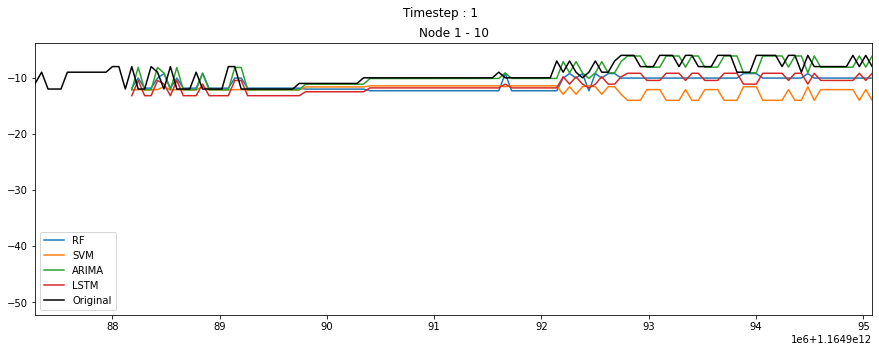

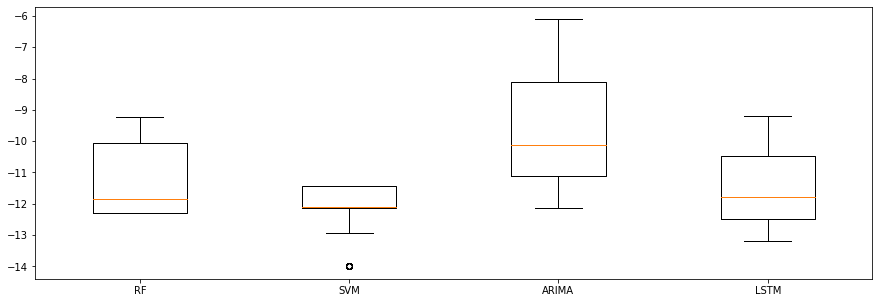

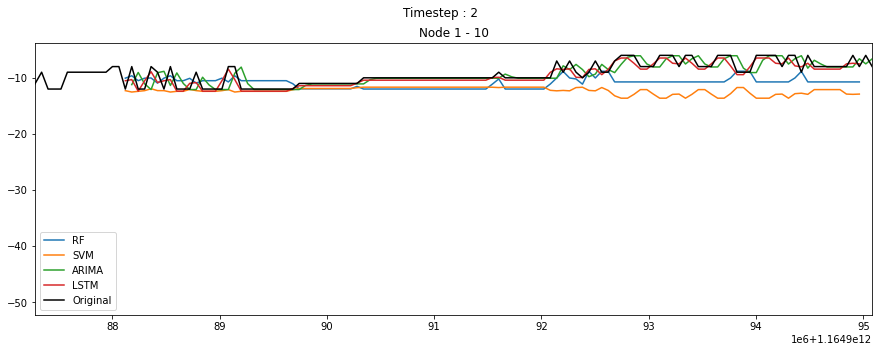

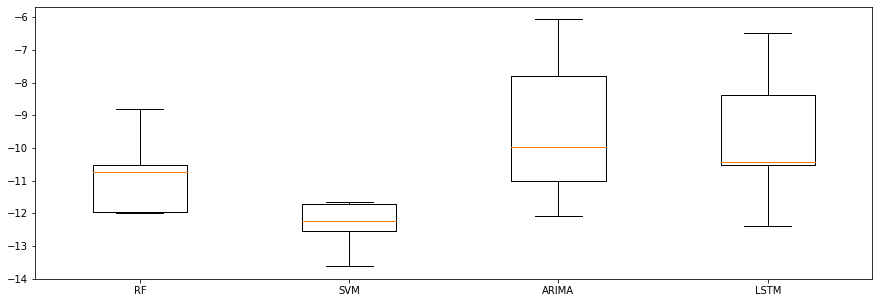

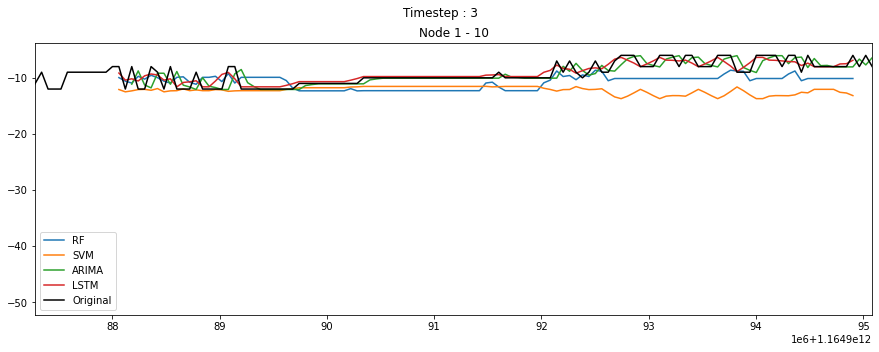

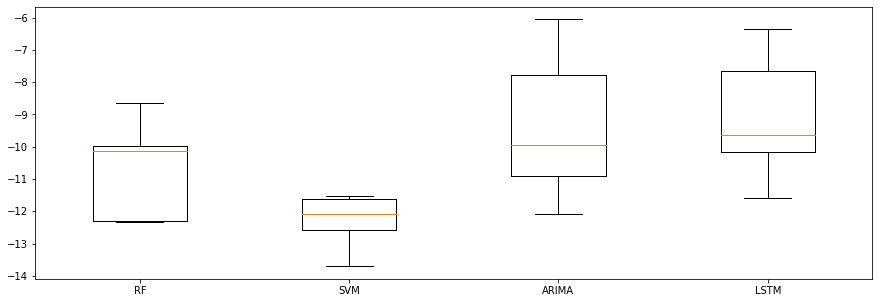

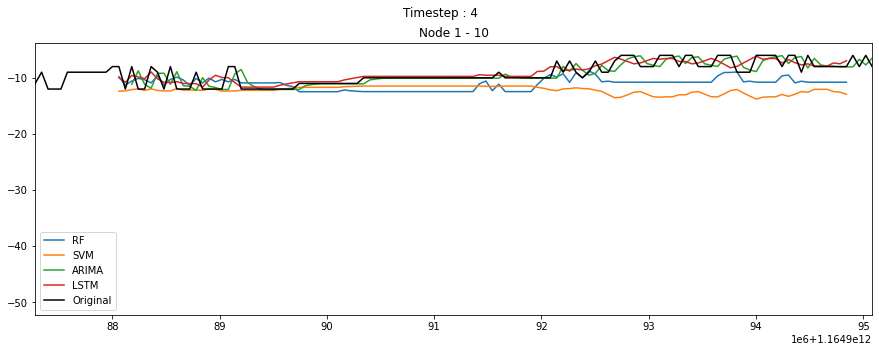

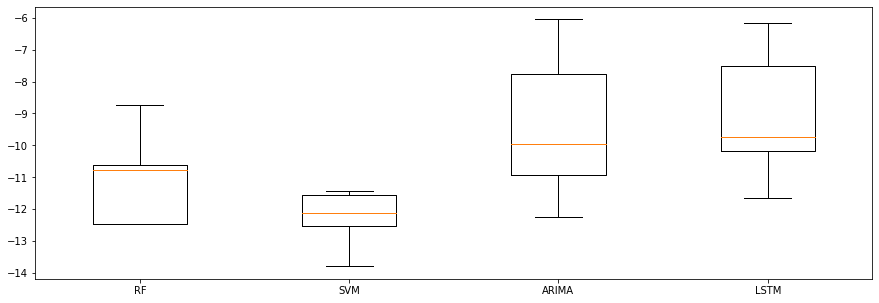

In [24]:
# --> Entrada modelos RF, SVM   dataX, dataY, pasos, diferenciada, datosOriginales, indicador

# --> Entrada ejecutarModelos  diferencia, promediada, path, nodeId, SrcNode, indicador 

#Variables de entrada
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataAritmetica.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiValue"
numNeuronas = 32
epocas = 32
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

ADF Estadistico: -12.576093
Valor p: 0.000000
Valores críticos
	1%: -3.453
	5%: -2.872
	10%: -2.572
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'Errores modelo RF : 1': (0.81073, 0.53281, 27.70542, 0.7934),
  'Errores modelo RF : 2': (1.22867, 0.72868, 27.68823, 0.68868),
  'Errores modelo RF : 3': (1.62141, 0.70173, 28.60646, 0.58917),
  'Errores modelo RF : 4': (1.35176, 0.83792, 27.33028, 0.65429)},
 {'Errores modelo SVR :1': (0.33005, 0.59959, 26.77949, 0.91589),
  'Errores modelo SVR :2': (0.38106, 0.57351, 26.85277, 0.90345),
  'Errores modelo SVR :3': (0.33662, 0.58234, 26.76067, 0.91471),
  'Errores modelo SVR :4': (0.36283, 0.59943, 26.62103, 0.90721)},
 {'Errores modelo ARIMA :1': (1.98889, 0.26583, 11.4395, 0.49317),
  'Errores modelo ARIMA :2': (1.91316, 0.42727, 11.48134, 0.51247),
  'Errores modelo ARIMA :3': (1.91714, 0.44254, 11.49183, 0.51146),
  'Errores modelo ARIMA :4': (1.93587, 0.45123, 11.5248, 0.50668)},
 {'Errores modelo LSTM : 1': (0.34879, 0.26475, 26.78935, 0.91112),
  'Errores modelo LSTM : 2': (0.30426, 0.09291, 27.23621, 0.92291),
  'Errores modelo LSTM : 3': (0.33065, 0.46244, 26.88255, 0.9162

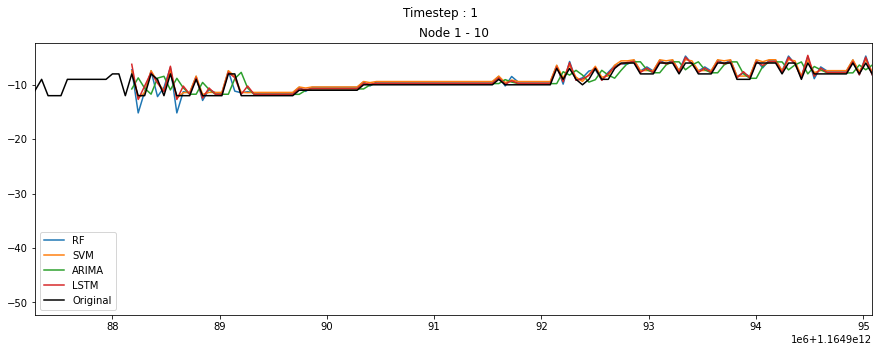

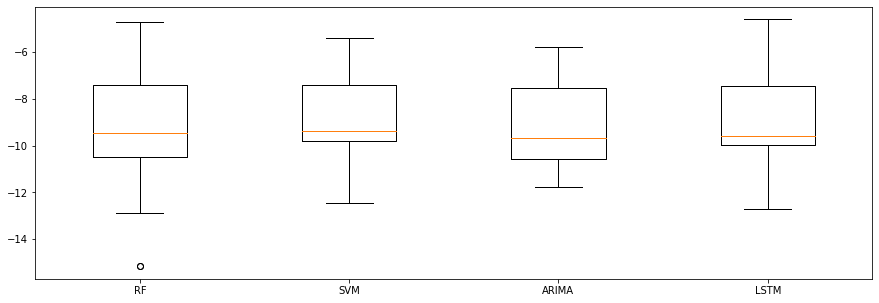

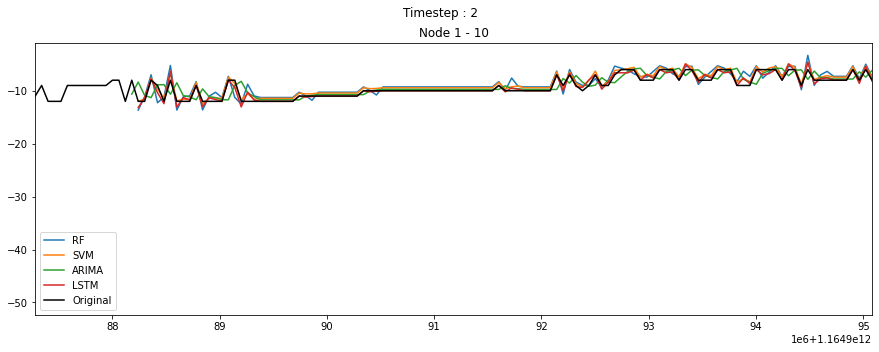

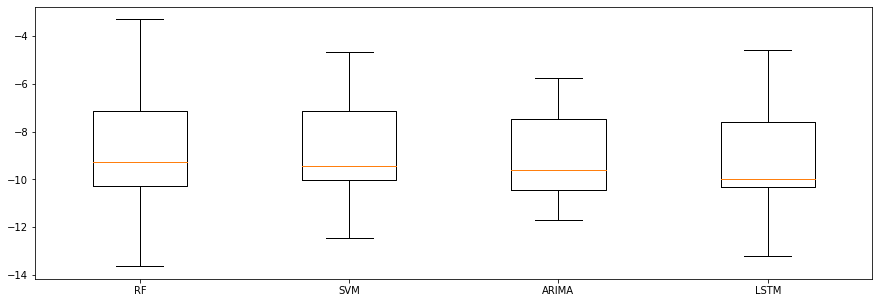

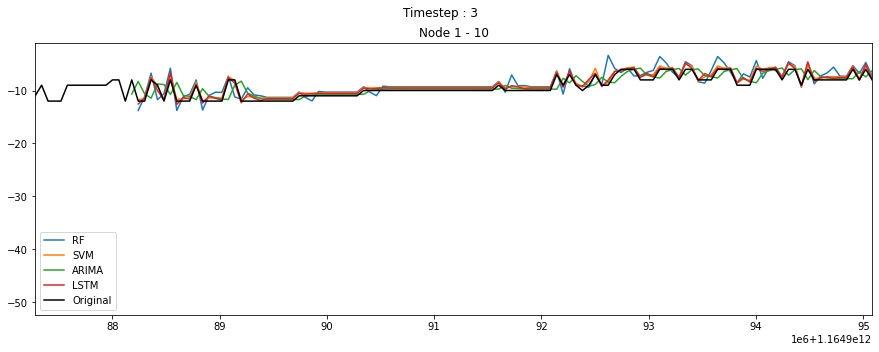

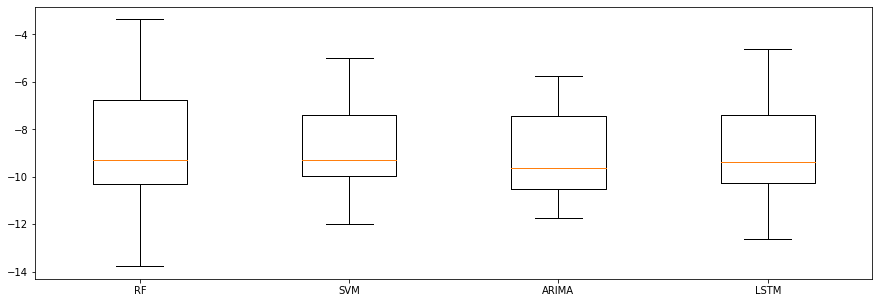

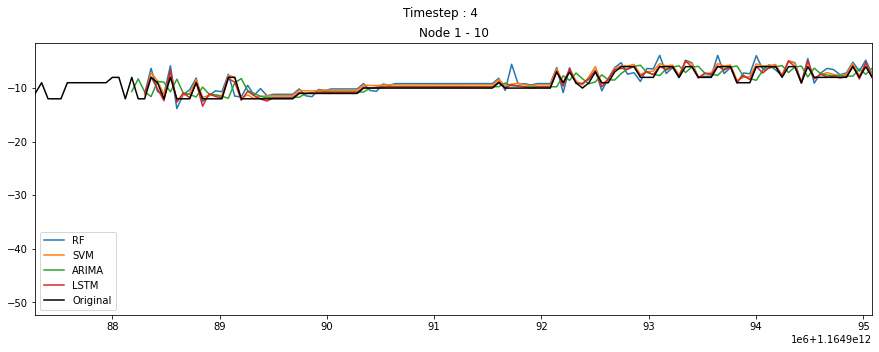

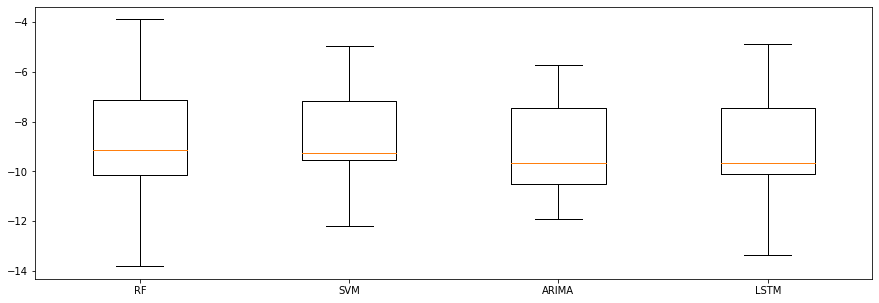

In [25]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

ADF Estadistico: -12.576093
Valor p: 0.000000
Valores críticos
	1%: -3.453
	5%: -2.872
	10%: -2.572
---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------
             Date  LqiValue
0             NaN       0.5
1             NaN       0.5
2             NaN       0.5
3             NaN       0.5
4    1.164978e+12       3.6
..            ...       ...
284  1.164995e+12       0.5
285  1.164995e+12       0.8
286  1.164995e+12       0.3
287  1.164995e+12       0.6
288  1.164995e+12       0.1

[289 rows x 2 columns]
                Date  SequenceNumber  ...  LqiTransform  RssiTransform
254              NaN             NaN  ...           NaN            NaN
527              NaN             NaN  ...           NaN            NaN
676              NaN             NaN  ...           NaN            NaN
909              NaN             NaN  ...           NaN            NaN
1053    1.164978e+12             0.8  ...         -44.0          212.2
...              ...             ...  ...

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             Date  LqiValue
0             NaN       0.5
1             NaN       0.5
2             NaN       0.5
3             NaN       0.5
4    1.164978e+12       3.6
..            ...       ...
284  1.164995e+12       0.5
285  1.164995e+12       0.8
286  1.164995e+12       0.3
287  1.164995e+12       0.6
288  1.164995e+12       0.1

[289 rows x 2 columns]
             Date  LqiValue
0             NaN       0.5
1             NaN       0.5
2             NaN       0.5
3             NaN       0.5
4    1.164978e+12       3.6
..            ...       ...
284  1.164995e+12       0.5
285  1.164995e+12       0.8
286  1.164995e+12       0.3
287  1.164995e+12       0.6
288  1.164995e+12       0.1

[289 rows x 2 columns]
             Date  LqiValue
0             NaN       0.5
1             NaN       0.5
2             NaN       0.5
3             NaN       0.5
4    1.164978e+12       3.6
..            ...       ...
284  1.164995e+12       0.5
285  1.164995e+12       0.8
286  1.164995e+12       0.3


({'Errores modelo RF : 1': (0.19568, 0.37037, 26.50418, 0.95014),
  'Errores modelo RF : 2': (0.232, 0.3497, 26.57255, 0.94122),
  'Errores modelo RF : 3': (0.26305, 0.43133, 26.43237, 0.93335),
  'Errores modelo RF : 4': (0.29384, 0.35267, 26.37249, 0.92485)},
 {'Errores modelo SVR :1': (0.16789, 0.43302, 26.50557, 0.95722),
  'Errores modelo SVR :2': (0.19263, 0.44272, 26.51482, 0.95119),
  'Errores modelo SVR :3': (0.23028, 0.47037, 26.36245, 0.94165),
  'Errores modelo SVR :4': (0.22686, 0.44168, 26.22103, 0.94198)},
 {'Errores modelo ARIMA :1': (0.11724, 0.12777, 2.76038, 0.95894),
  'Errores modelo ARIMA :2': (1.91316, 0.42727, 11.48134, 0.51247),
  'Errores modelo ARIMA :3': (1.91714, 0.44254, 11.49183, 0.51146),
  'Errores modelo ARIMA :4': (1.93587, 0.45123, 11.5248, 0.50668)},
 {'Errores modelo LSTM : 1': (0.18714, 0.46659, 26.56531, 0.95231),
  'Errores modelo LSTM : 2': (0.16392, 0.41955, 26.60206, 0.95847),
  'Errores modelo LSTM : 3': (0.13704, 0.37627, 26.58134, 0.96528)

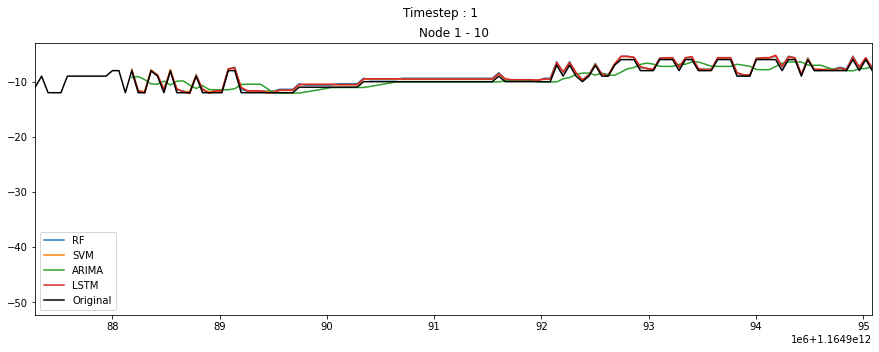

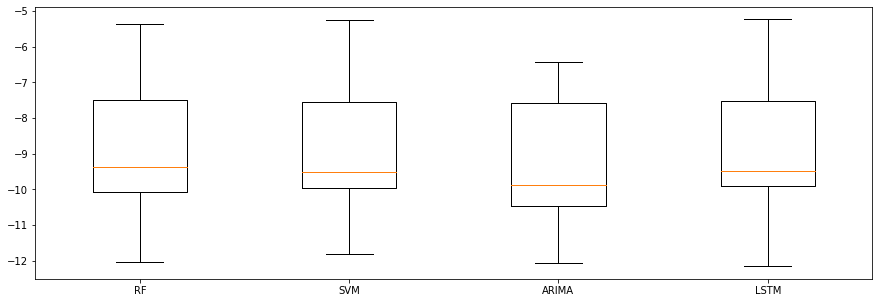

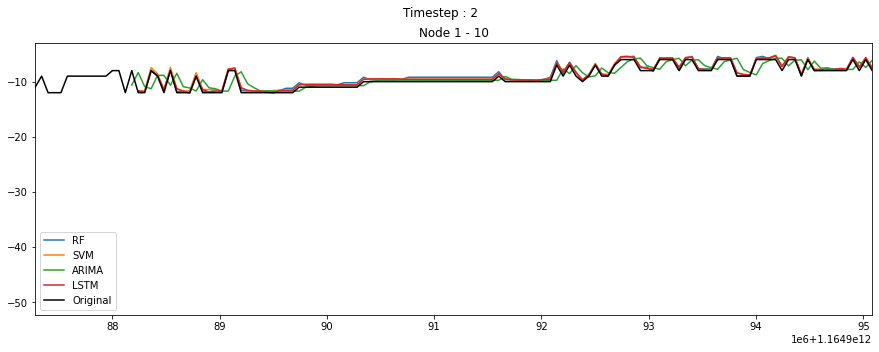

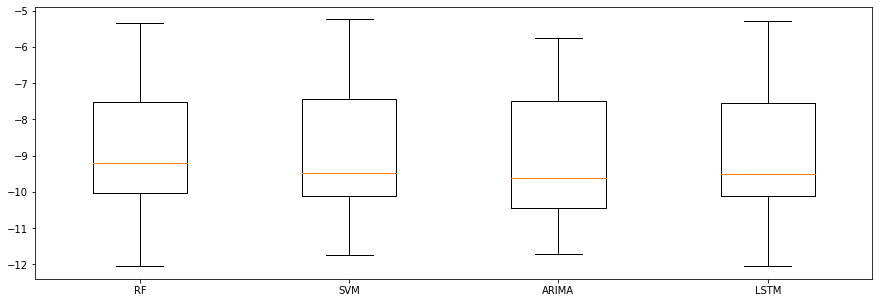

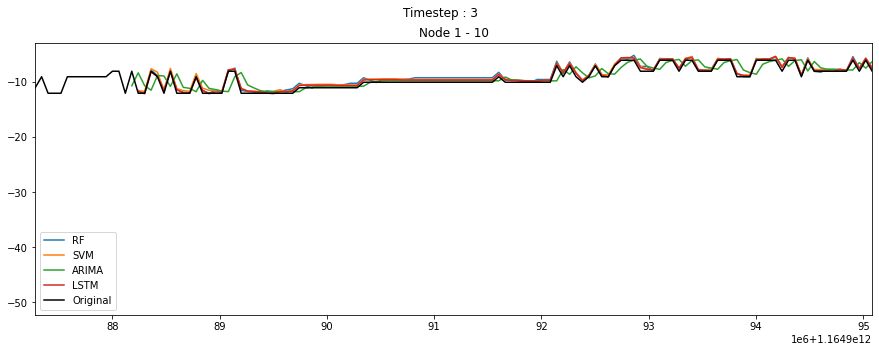

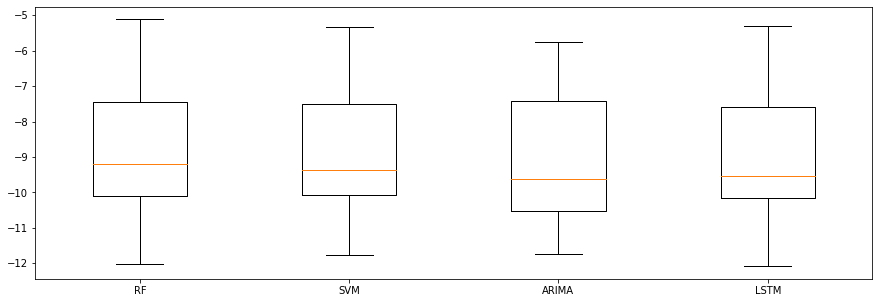

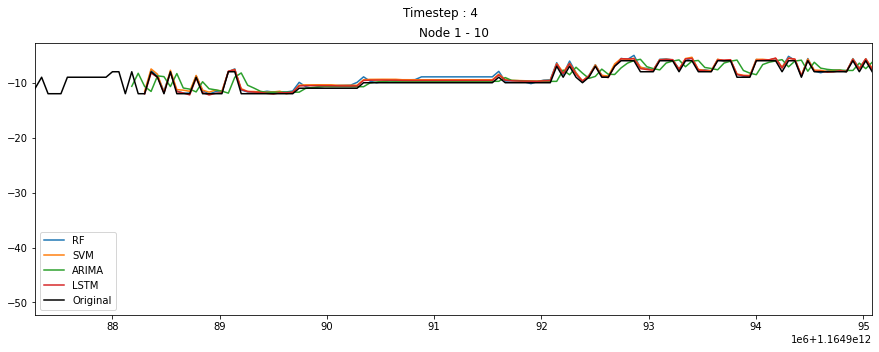

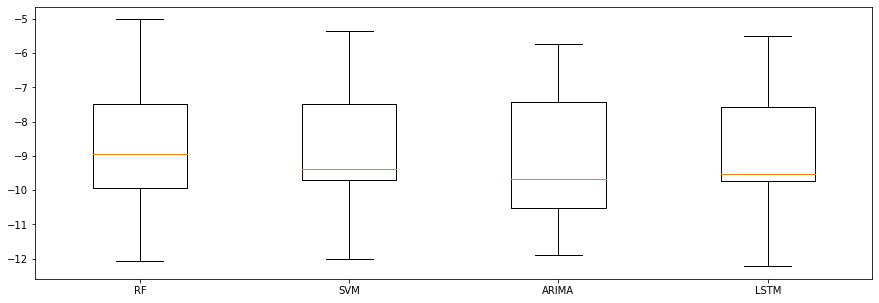

In [26]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

# **Distribución arimética**

* Datos en orden par son multiplicados por un factor 0.02
* Datos en orden impar son multiplicados por un factor 0.03
* Datos en orden múltiplo de 5 son multiplicados por un factor 0.05

ADF Estadistico: -12.576093
Valor p: 0.000000
Valores críticos
	1%: -3.453
	5%: -2.872
	10%: -2.572
----------------------- SIN DIFERENCIAS ---------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opt

({'Errores modelo RF : 1': (6.37811, 1.93965, 32.87883, -0.47901),
  'Errores modelo RF : 2': (7.30572, 2.55754, 31.19247, -0.68489),
  'Errores modelo RF : 3': (6.54017, 2.3861, 30.43936, -0.50833),
  'Errores modelo RF : 4': (7.32804, 2.41375, 30.84641, -0.70099)},
 {'Errores modelo SVR :1': (16.97701, 2.18163, 43.10679, -2.93677),
  'Errores modelo SVR :2': (14.92226, 2.19007, 41.05491, -2.44146),
  'Errores modelo SVR :3': (14.6303, 2.08304, 40.30032, -2.37412),
  'Errores modelo SVR :4': (14.65783, 2.10402, 40.15453, -2.40239)},
 {'Errores modelo ARIMA :1': (2.57193, 0.82206, 12.98066, 0.4036),
  'Errores modelo ARIMA :2': (2.11431, 0.79262, 12.30257, 0.50972),
  'Errores modelo ARIMA :3': (2.00306, 0.76412, 12.50677, 0.53552),
  'Errores modelo ARIMA :4': (1.99471, 0.76265, 12.53002, 0.53745)},
 {'Errores modelo LSTM : 1': (5.9913, 1.52845, 26.64932, -0.38931),
  'Errores modelo LSTM : 2': (3.34428, 1.0559, 18.97336, 0.22872),
  'Errores modelo LSTM : 3': (3.56887, 1.0282, 19.762

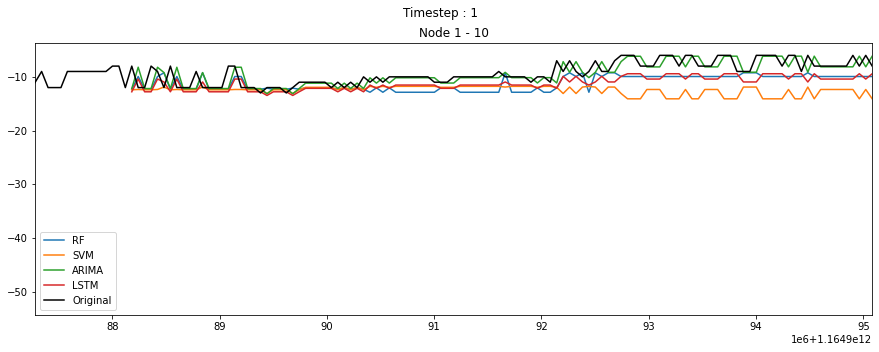

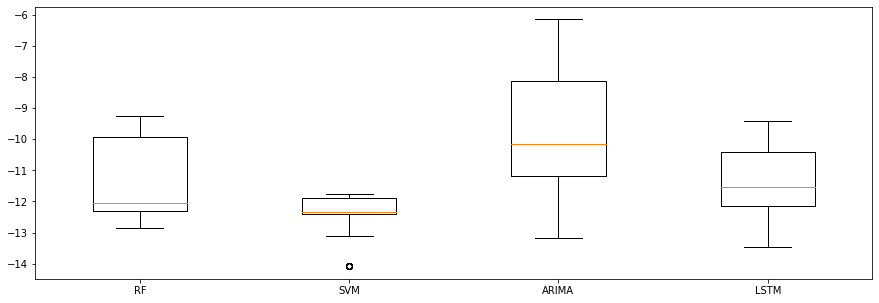

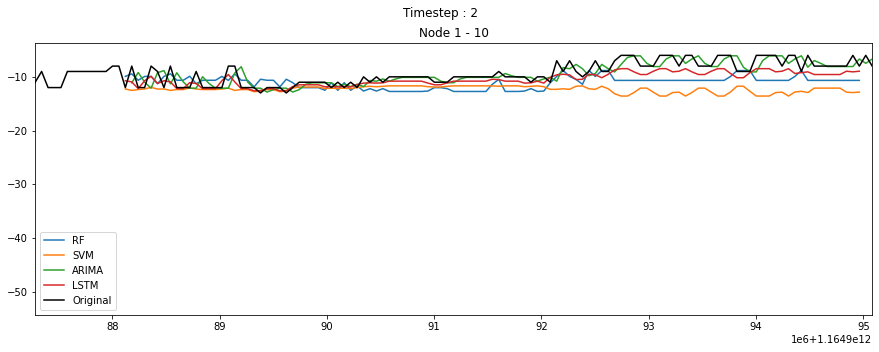

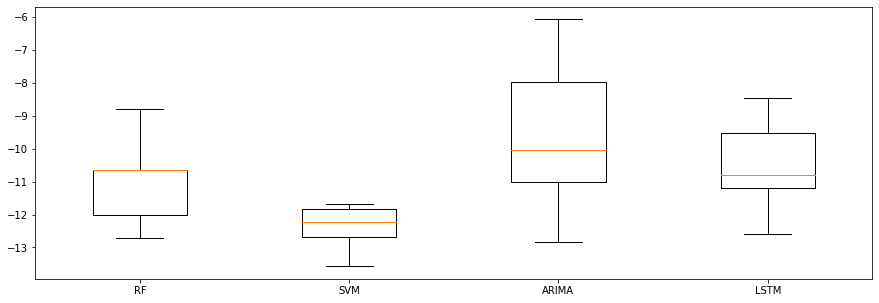

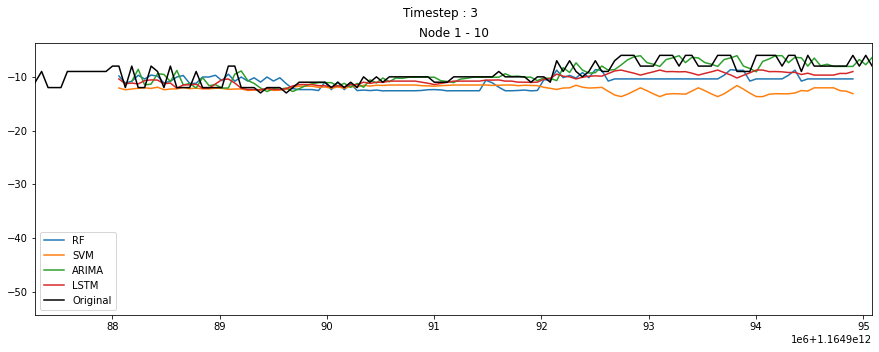

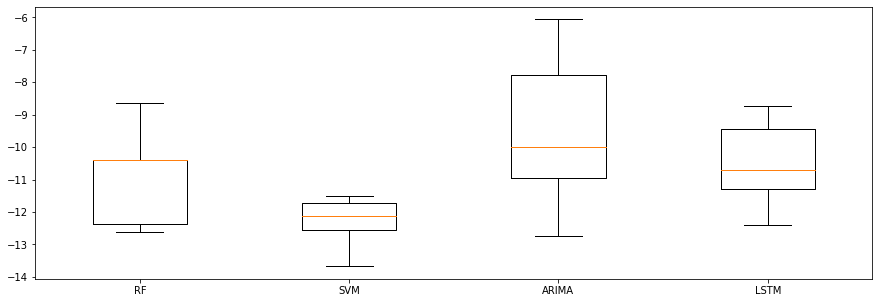

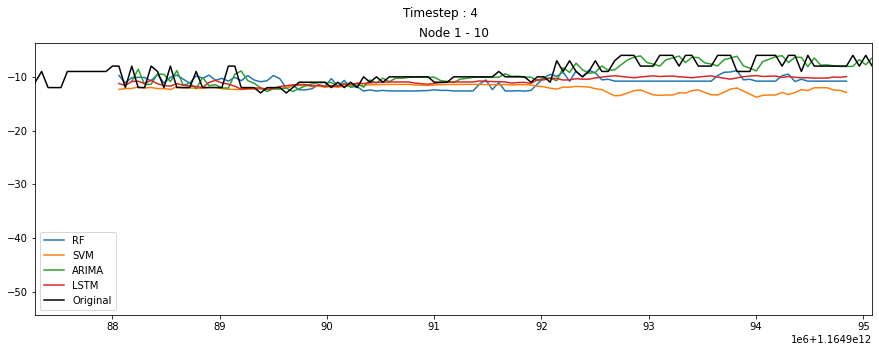

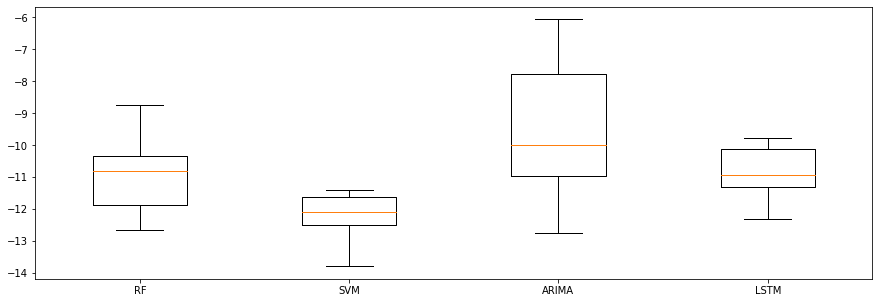

In [27]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataAritmetica.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 1
epocas = 32
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

ADF Estadistico: -12.576093
Valor p: 0.000000
Valores críticos
	1%: -3.453
	5%: -2.872
	10%: -2.572
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


({'Errores modelo RF : 1': (0.89636, 0.45581, 28.38188, 0.79215),
  'Errores modelo RF : 2': (2.16259, 0.38329, 29.39062, 0.50125),
  'Errores modelo RF : 3': (3.22926, 0.66894, 30.26565, 0.25525),
  'Errores modelo RF : 4': (2.07188, 1.09092, 29.4763, 0.51907)},
 {'Errores modelo SVR :1': (0.76828, 0.59999, 28.36971, 0.82185),
  'Errores modelo SVR :2': (0.63191, 0.4074, 28.08386, 0.85426),
  'Errores modelo SVR :3': (0.52132, 0.50772, 27.85068, 0.87977),
  'Errores modelo SVR :4': (0.43363, 0.46107, 27.67611, 0.89935)},
 {'Errores modelo ARIMA :1': (2.13845, 0.79331, 12.36617, 0.50412),
  'Errores modelo ARIMA :2': (2.05189, 0.87643, 12.54016, 0.52419),
  'Errores modelo ARIMA :3': (2.03907, 0.90077, 12.47836, 0.52716),
  'Errores modelo ARIMA :4': (2.04367, 0.86432, 12.48182, 0.5261)},
 {'Errores modelo LSTM : 1': (0.20598, 0.44398, 27.80536, 0.95224),
  'Errores modelo LSTM : 2': (0.1866, 0.43197, 27.82453, 0.95696),
  'Errores modelo LSTM : 3': (0.25058, 0.31469, 27.87534, 0.94221

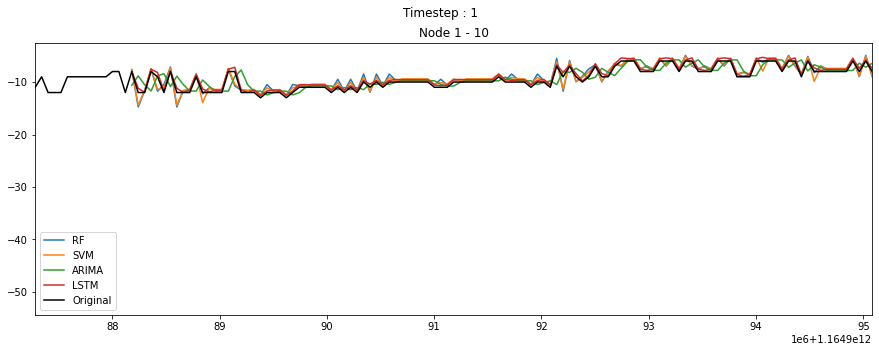

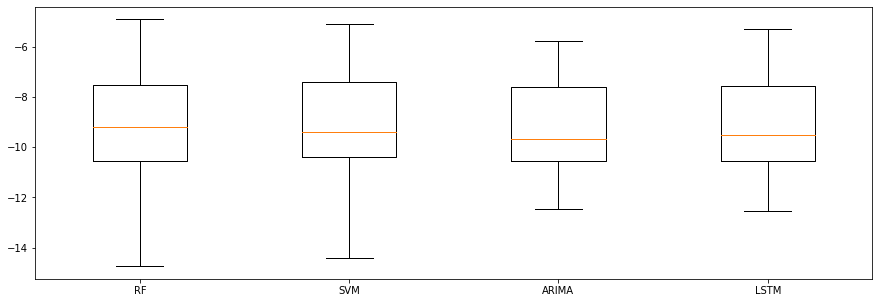

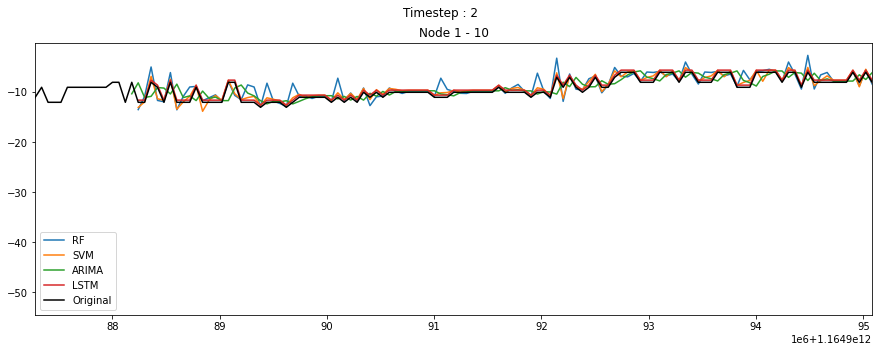

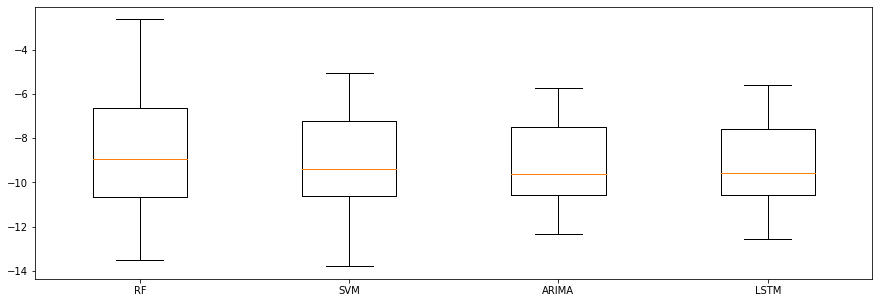

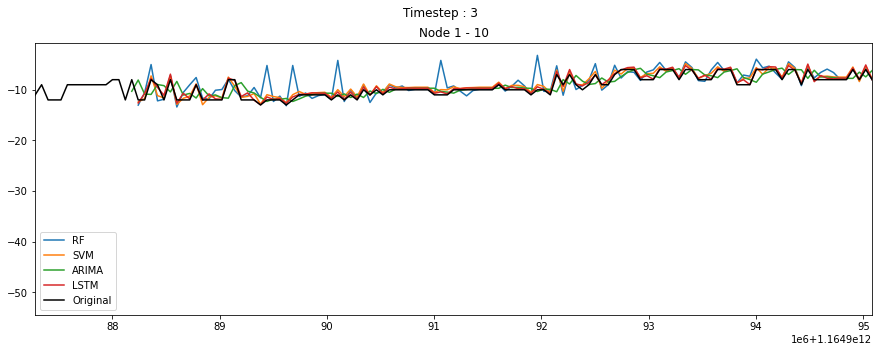

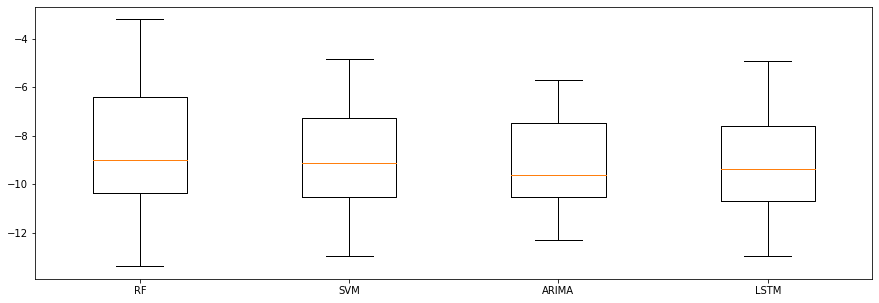

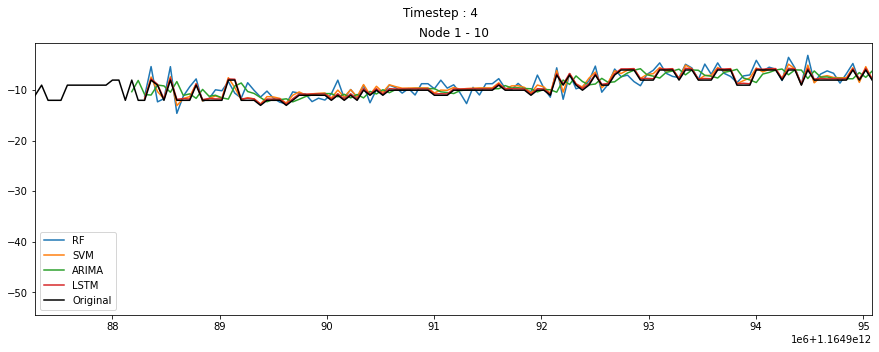

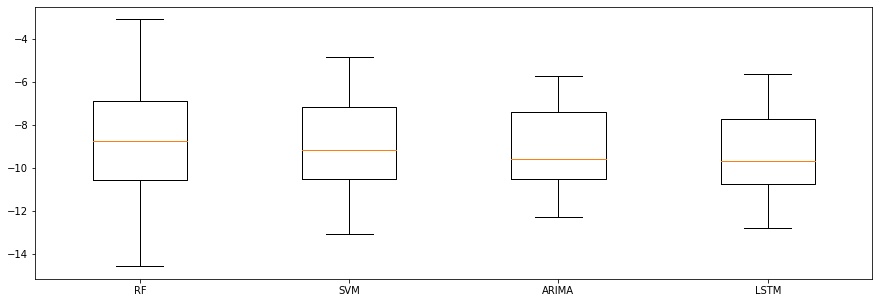

In [28]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

ADF Estadistico: -12.576093
Valor p: 0.000000
Valores críticos
	1%: -3.453
	5%: -2.872
	10%: -2.572
---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------
             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12           3.6
..            ...           ...
284  1.164995e+12           0.5
285  1.164995e+12           0.8
286  1.164995e+12           0.3
287  1.164995e+12           0.6
288  1.164995e+12           0.1

[289 rows x 2 columns]
                Date  SequenceNumber  ...  LqiTransform  RssiTransform
254              NaN             NaN  ...           0.5            NaN
527              NaN             NaN  ...           0.5            NaN
676              NaN             NaN  ...           0.5            NaN
909              NaN             NaN  ...           0.5            NaN
1053    1.164978e+12             0.8  ...         -44.0         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12           3.6
..            ...           ...
284  1.164995e+12           0.5
285  1.164995e+12           0.8
286  1.164995e+12           0.3
287  1.164995e+12           0.6
288  1.164995e+12           0.1

[289 rows x 2 columns]
             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12           3.6
..            ...           ...
284  1.164995e+12           0.5
285  1.164995e+12           0.8
286  1.164995e+12           0.3
287  1.164995e+12           0.6
288  1.164995e+12           0.1

[289 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12           3.6
..            ...           ...
284  1.164995e+12           0.5
285  1.164995e+12           0.8
286  1.164995e+12           0.3
287  1.164995e+12           0.6
288  1.164995e+12           0.1

[289 rows x 2 columns]


({'Errores modelo RF : 1': (0.13678, 0.22625, 28.03505, 0.96828),
  'Errores modelo RF : 2': (0.19274, 0.27734, 28.03306, 0.95555),
  'Errores modelo RF : 3': (0.27505, 0.315, 28.0721, 0.93657),
  'Errores modelo RF : 4': (0.26982, 0.27867, 28.01213, 0.93737)},
 {'Errores modelo SVR :1': (0.10409, 0.22972, 27.80014, 0.97586),
  'Errores modelo SVR :2': (0.11062, 0.2226, 27.86759, 0.97449),
  'Errores modelo SVR :3': (0.11831, 0.25709, 27.832, 0.97271),
  'Errores modelo SVR :4': (0.119, 0.26951, 27.57515, 0.97238)},
 {'Errores modelo ARIMA :1': (0.1311, 0.23825, 3.00347, 0.9583),
  'Errores modelo ARIMA :2': (2.05189, 0.87643, 12.54016, 0.52419),
  'Errores modelo ARIMA :3': (2.03907, 0.90077, 12.47836, 0.52716),
  'Errores modelo ARIMA :4': (2.04367, 0.86432, 12.48182, 0.5261)},
 {'Errores modelo LSTM : 1': (0.12649, 0.3398, 27.76987, 0.97067),
  'Errores modelo LSTM : 2': (0.11564, 0.29675, 27.82722, 0.97333),
  'Errores modelo LSTM : 3': (0.14331, 0.37856, 27.81153, 0.96695),
  'Err

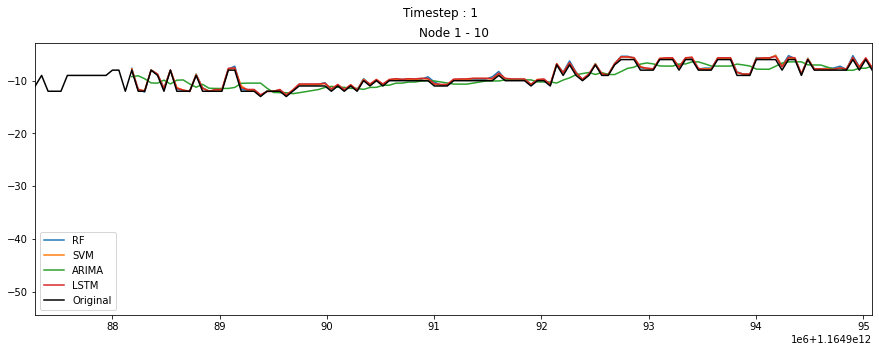

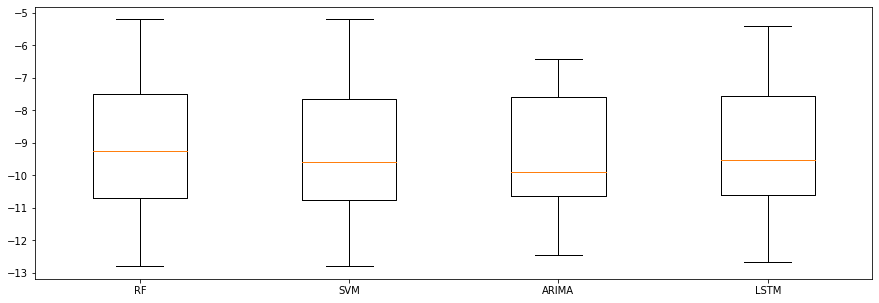

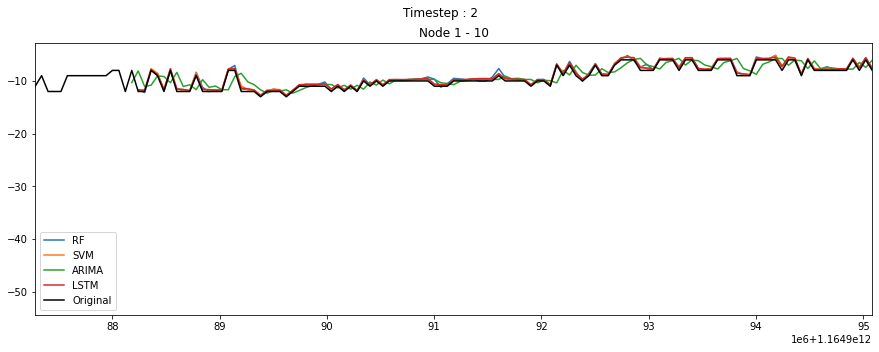

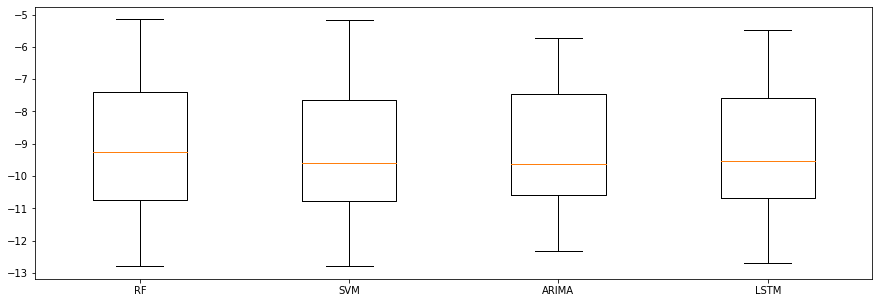

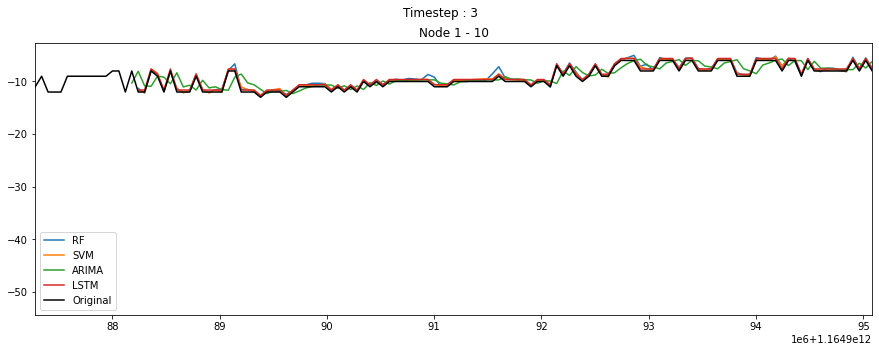

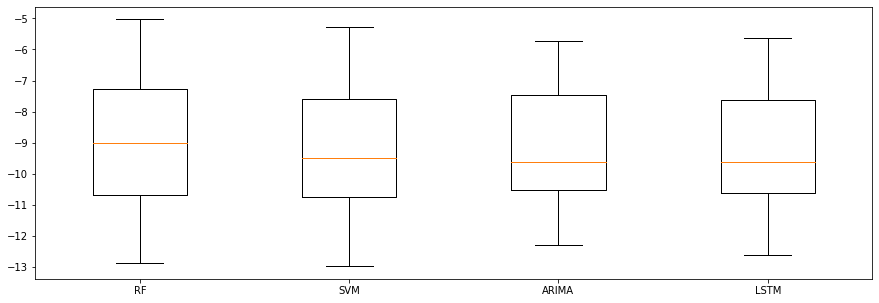

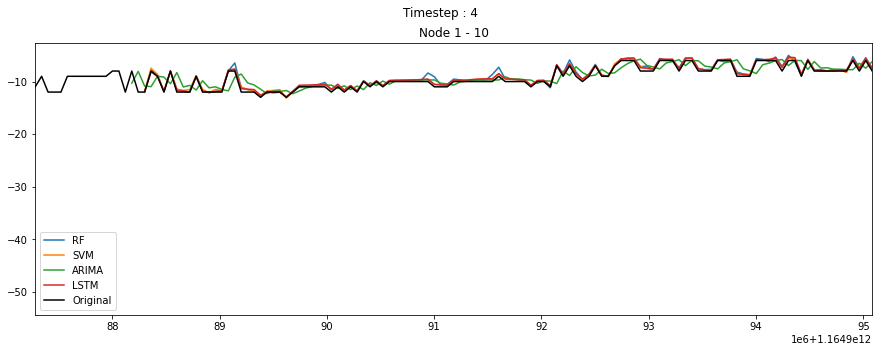

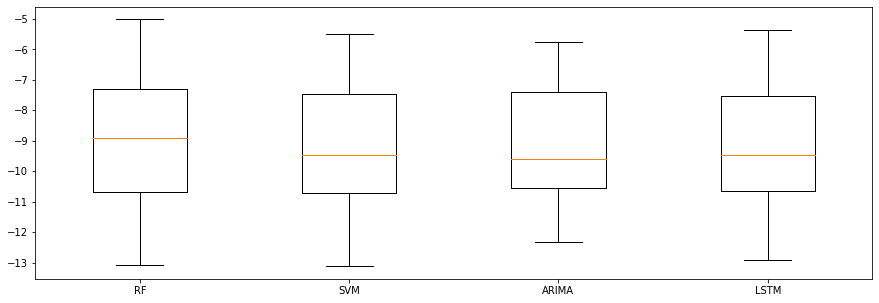

In [29]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

# **Distribución Poisson**

* Para LQI
  *   media = 15
  
* Para RSSI
  * media = 210

No acumulado


ADF Estadistico: -2.126024
Valor p: 0.234180
Valores críticos
	1%: -3.454
	5%: -2.872
	10%: -2.572
----------------------- SIN DIFERENCIAS ---------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'Errores modelo RF : 1': (833.16263, 28.23615, 226.70765, -0.1722),
  'Errores modelo RF : 2': (820.68499, 24.63605, 215.17515, -0.15085),
  'Errores modelo RF : 3': (892.11125, 29.66078, 216.12307, -0.25101),
  'Errores modelo RF : 4': (824.34596, 27.06414, 224.37503, -0.17248)},
 {'Errores modelo SVR :1': (387.7546, 4.44303, 168.7486, 0.45446),
  'Errores modelo SVR :2': (311.1793, 5.51474, 168.09937, 0.56363),
  'Errores modelo SVR :3': (274.18825, 4.84261, 167.69841, 0.6155),
  'Errores modelo SVR :4': (265.65116, 4.45567, 168.13548, 0.62216)},
 {'Errores modelo ARIMA :1': (382.72772, 4.83504, 72.0949, 0.46153),
  'Errores modelo ARIMA :2': (329.39499, 4.21757, 64.98775, 0.53656),
  'Errores modelo ARIMA :3': (297.85825, 5.71462, 63.90291, 0.58093),
  'Errores modelo ARIMA :4': (303.87467, 7.41051, 63.85155, 0.57247)},
 {'Errores modelo LSTM : 1': (512.33296, 12.97553, 71.82233, 0.27918),
  'Errores modelo LSTM : 2': (335.21203, 6.21789, 70.09014, 0.52993),
  'Errores modelo LSTM

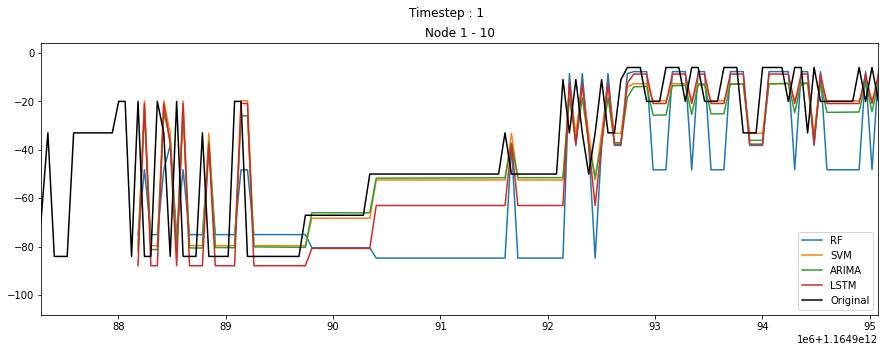

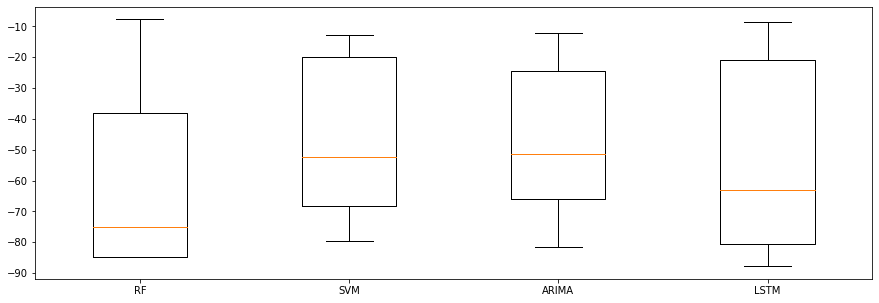

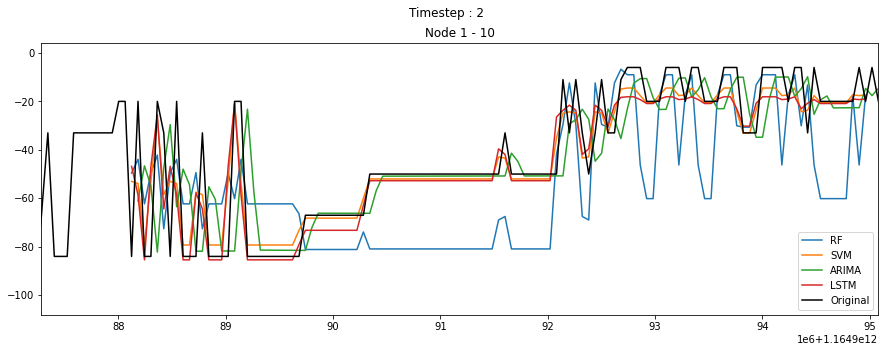

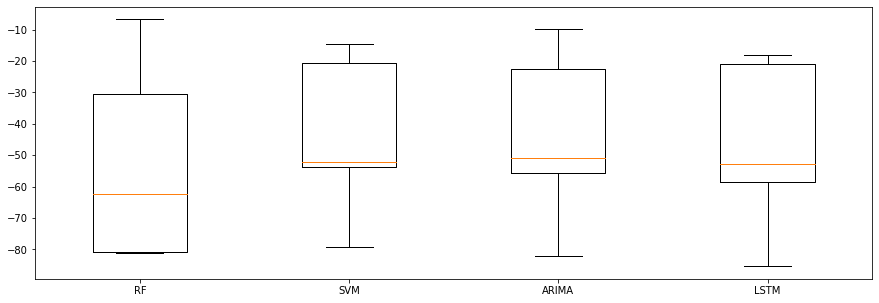

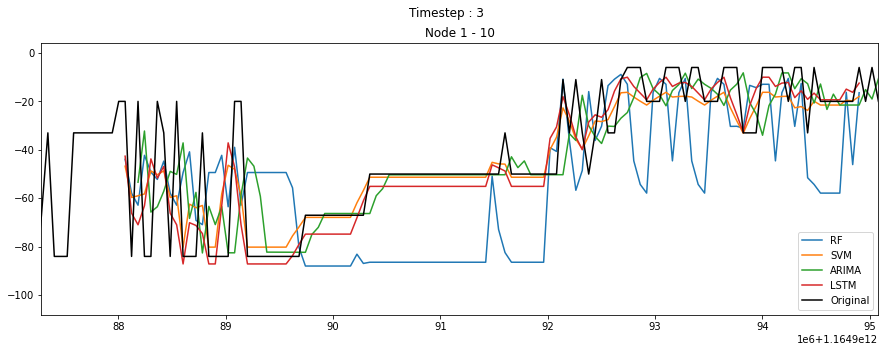

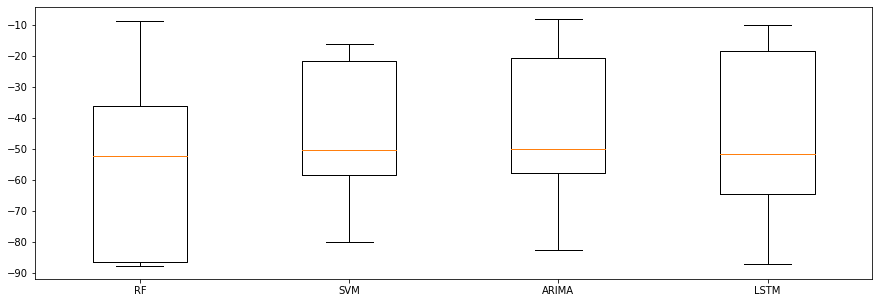

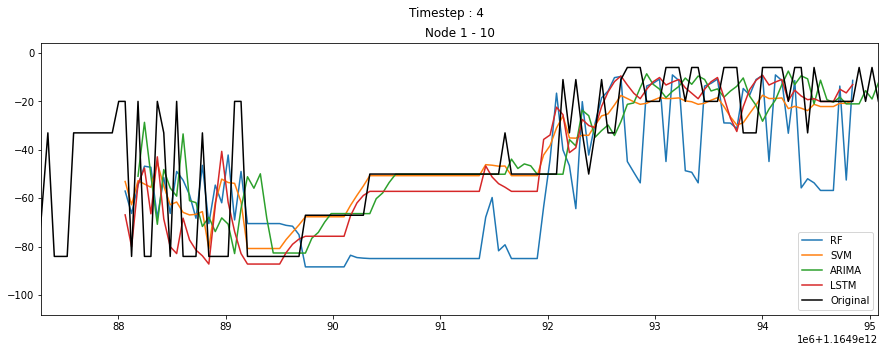

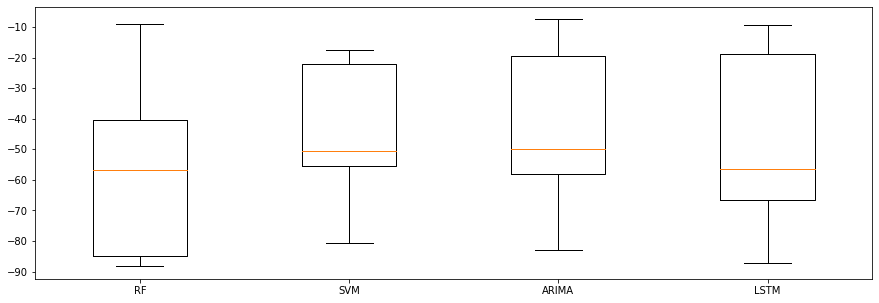

In [30]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataPoisson.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 1
epocas = 32
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

ADF Estadistico: -2.126024
Valor p: 0.234180
Valores críticos
	1%: -3.454
	5%: -2.872
	10%: -2.572
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


({'Errores modelo RF : 1': (83.04368, 2.34627, 174.83193, 0.88316),
  'Errores modelo RF : 2': (123.95529, 1.18664, 172.31767, 0.82618),
  'Errores modelo RF : 3': (185.54362, 3.60722, 168.58439, 0.73981),
  'Errores modelo RF : 4': (206.02063, 4.1465, 169.27219, 0.70697)},
 {'Errores modelo SVR :1': (2.73269, 0.59977, 166.84139, 0.99616),
  'Errores modelo SVR :2': (0.99564, 0.39994, 167.11143, 0.9986),
  'Errores modelo SVR :3': (0.78987, 0.39985, 166.93974, 0.99889),
  'Errores modelo SVR :4': (0.67617, 0.39978, 166.06917, 0.99904)},
 {'Errores modelo ARIMA :1': (341.91717, 5.47135, 56.06967, 0.51895),
  'Errores modelo ARIMA :2': (303.53855, 6.57456, 60.01018, 0.57294),
  'Errores modelo ARIMA :3': (308.28403, 6.84486, 61.90886, 0.56627),
  'Errores modelo ARIMA :4': (307.30073, 7.48868, 62.0133, 0.56765)},
 {'Errores modelo LSTM : 1': (72.71718, 0.86028, 173.20848, 0.89769),
  'Errores modelo LSTM : 2': (0.0088, 0.09383, 166.77495, 0.99999),
  'Errores modelo LSTM : 3': (0.07921, 

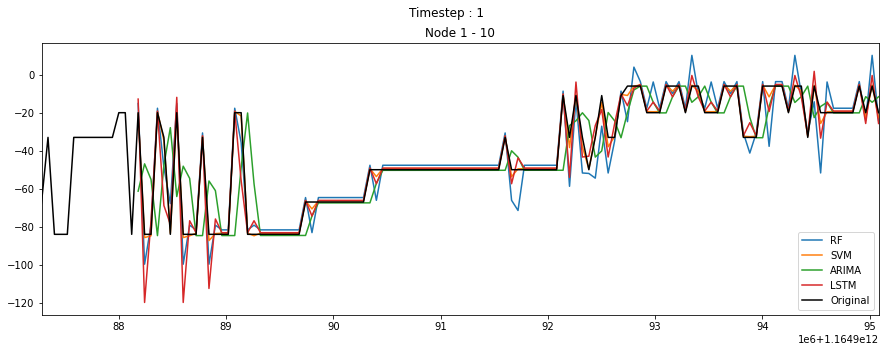

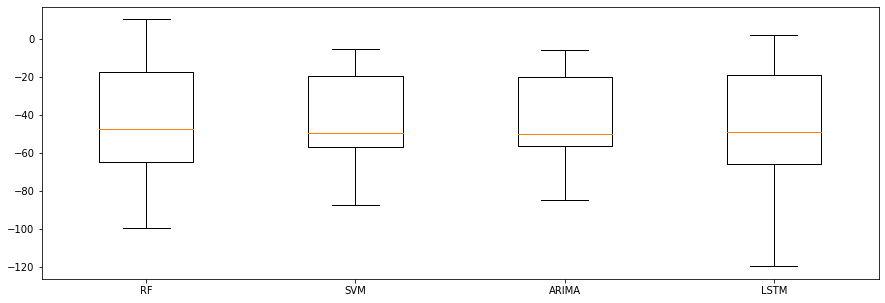

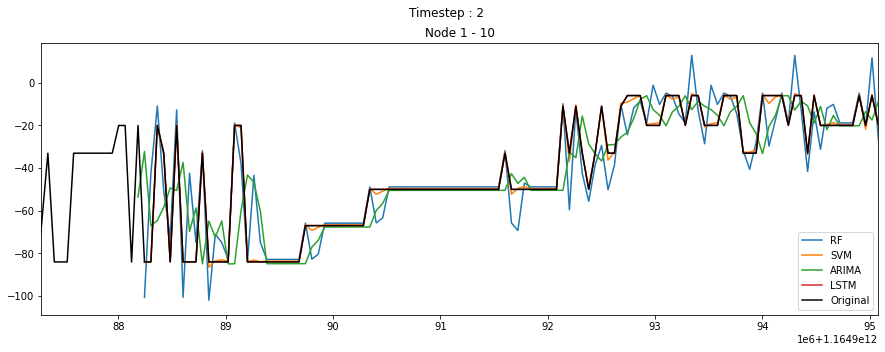

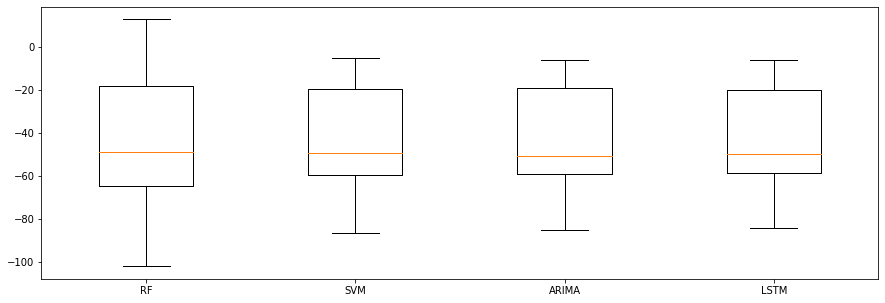

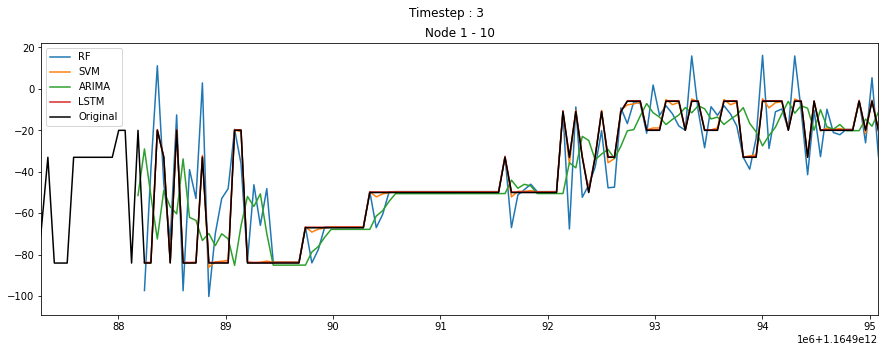

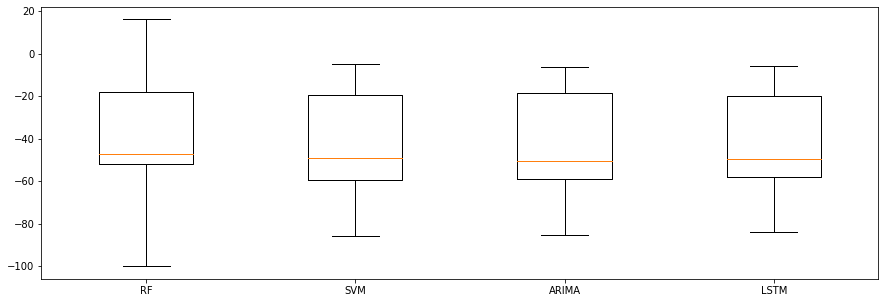

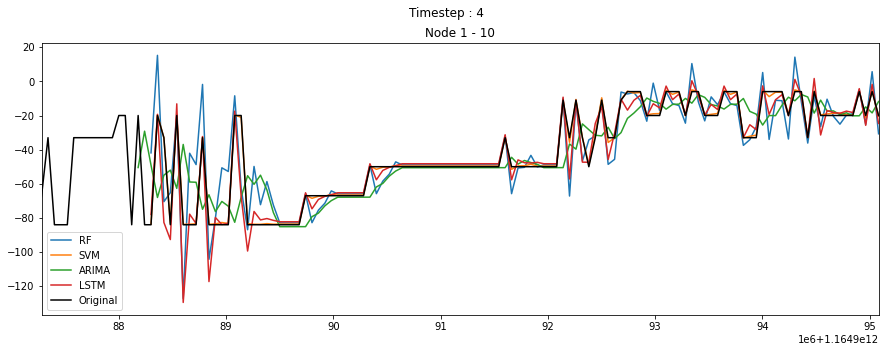

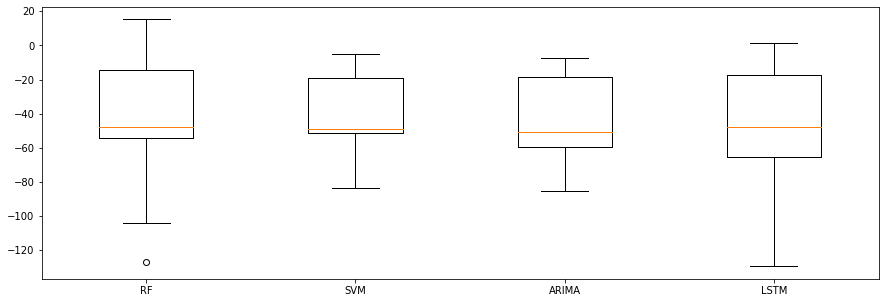

In [31]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

ADF Estadistico: -2.126024
Valor p: 0.234180
Valores críticos
	1%: -3.454
	5%: -2.872
	10%: -2.572
---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------
             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12           0.5
..            ...           ...
284  1.164995e+12           0.5
285  1.164995e+12           3.2
286  1.164995e+12           0.3
287  1.164995e+12           3.0
288  1.164995e+12           0.1

[289 rows x 2 columns]
             Date  SequenceNumber  ...  LqiTransform  RssiTransform
0             NaN             NaN  ...           0.5            NaN
1             NaN             NaN  ...           0.5            NaN
2             NaN             NaN  ...           0.5            NaN
3             NaN             NaN  ...           0.5            NaN
4    1.164978e+12             0.8  ...          -1.0           10.2
..          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12           0.5
..            ...           ...
284  1.164995e+12           0.5
285  1.164995e+12           3.2
286  1.164995e+12           0.3
287  1.164995e+12           3.0
288  1.164995e+12           0.1

[289 rows x 2 columns]
             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12           0.5
..            ...           ...
284  1.164995e+12           0.5
285  1.164995e+12           3.2
286  1.164995e+12           0.3
287  1.164995e+12           3.0
288  1.164995e+12           0.1

[289 rows x 2 columns]
             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12       

({'Errores modelo RF : 1': (6.59618, 0.80354, 168.25104, 0.99072),
  'Errores modelo RF : 2': (5.08449, 0.98168, 169.08089, 0.99287),
  'Errores modelo RF : 3': (4.31511, 0.90533, 168.25589, 0.99395),
  'Errores modelo RF : 4': (4.58319, 1.38413, 168.05849, 0.99348)},
 {'Errores modelo SVR :1': (0.5412, 0.3379, 166.3083, 0.99924),
  'Errores modelo SVR :2': (0.19184, 0.39966, 166.46939, 0.99973),
  'Errores modelo SVR :3': (0.21245, 0.39972, 165.98284, 0.9997),
  'Errores modelo SVR :4': (0.25129, 0.40505, 165.40139, 0.99964)},
 {'Errores modelo ARIMA :1': (22.04602, 1.79941, 9.23282, 0.95804),
  'Errores modelo ARIMA :2': (303.53855, 6.57456, 60.01018, 0.57294),
  'Errores modelo ARIMA :3': (308.28403, 6.84486, 61.90886, 0.56627),
  'Errores modelo ARIMA :4': (307.30073, 7.48868, 62.0133, 0.56765)},
 {'Errores modelo LSTM : 1': (1.63119, 0.41403, 166.40403, 0.99771),
  'Errores modelo LSTM : 2': (0.00318, 0.05076, 166.83448, 1.0),
  'Errores modelo LSTM : 3': (1.47207, 0.73467, 166.89

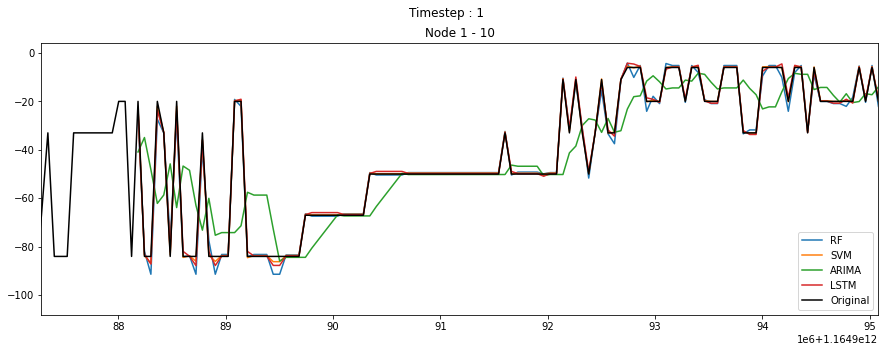

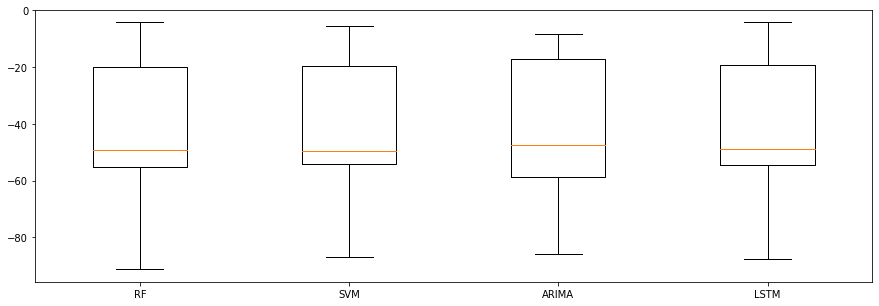

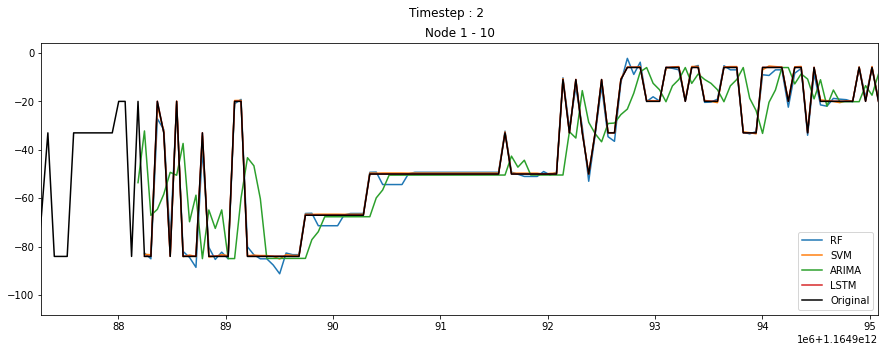

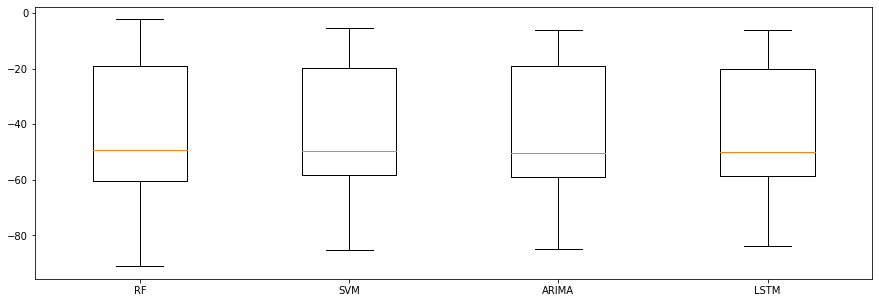

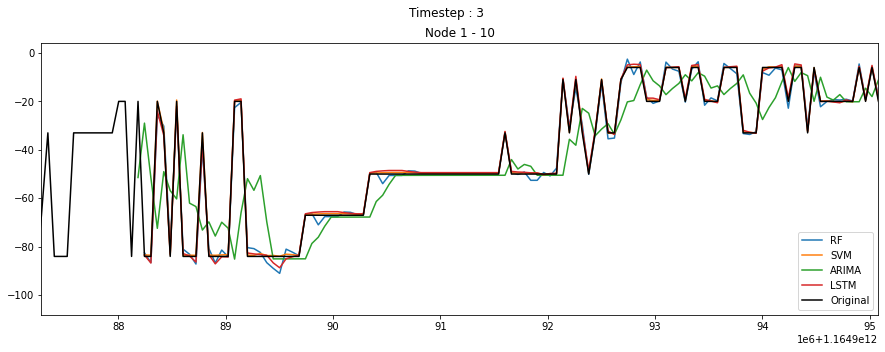

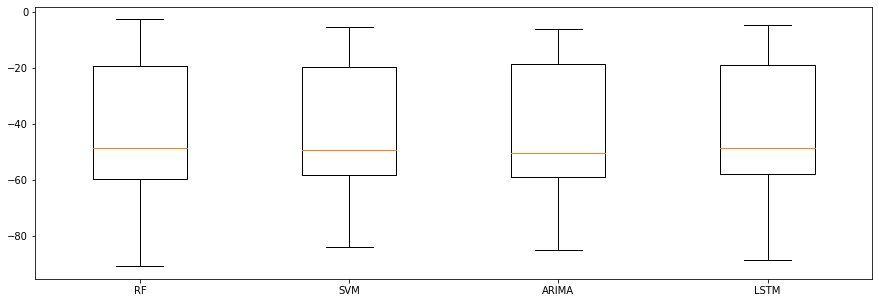

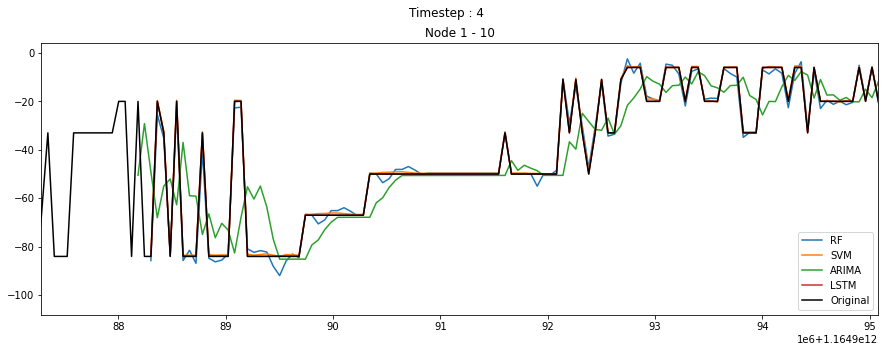

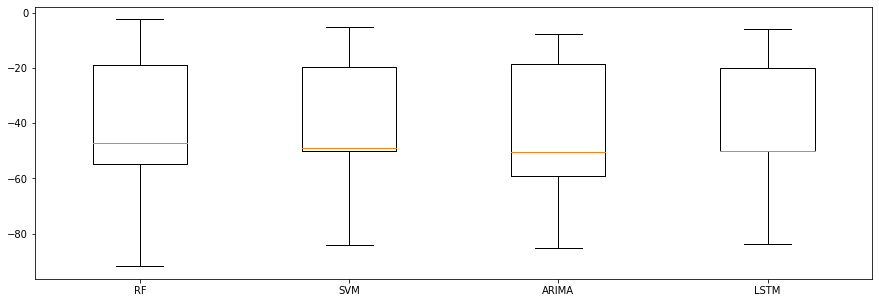

In [32]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

# **Distribución Gamma**
* Para LQI
  alfa = 10
  beta = 3

* Para RSSI
  alfa = 10
  beta = 15

No acumulado

ADF Estadistico: -3.994007
Valor p: 0.001442
Valores críticos
	1%: -3.454
	5%: -2.872
	10%: -2.572
----------------------- SIN DIFERENCIAS ---------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


({'Errores modelo RF : 1': (0.27248, 0.53745, 50.1826, -0.9894),
  'Errores modelo RF : 2': (0.17285, 0.35291, 35.82908, -0.25325),
  'Errores modelo RF : 3': (0.20113, 0.36272, 35.59175, -0.45833),
  'Errores modelo RF : 4': (0.14593, 0.26514, 32.01263, -0.09755)},
 {'Errores modelo SVR :1': (2.09625, 1.51908, 136.91591, -14.305),
  'Errores modelo SVR :2': (1.92996, 1.46172, 131.37983, -12.99328),
  'Errores modelo SVR :3': (1.3449, 1.21908, 109.91015, -8.75127),
  'Errores modelo SVR :4': (1.1003, 1.10012, 99.62142, -7.2752)},
 {'Errores modelo ARIMA :1': (0.12517, 0.15807, 21.01652, 0.08611),
  'Errores modelo ARIMA :2': (0.10119, 0.12226, 17.82869, 0.26121),
  'Errores modelo ARIMA :3': (0.09547, 0.11074, 16.85192, 0.30294),
  'Errores modelo ARIMA :4': (0.09716, 0.11521, 17.28151, 0.2906)},
 {'Errores modelo LSTM : 1': (3.89983, 1.99407, 182.99252, -27.47321),
  'Errores modelo LSTM : 2': (1.5323, 1.2665, 114.9395, -10.11001),
  'Errores modelo LSTM : 3': (2.91747, 1.75909, 159.2

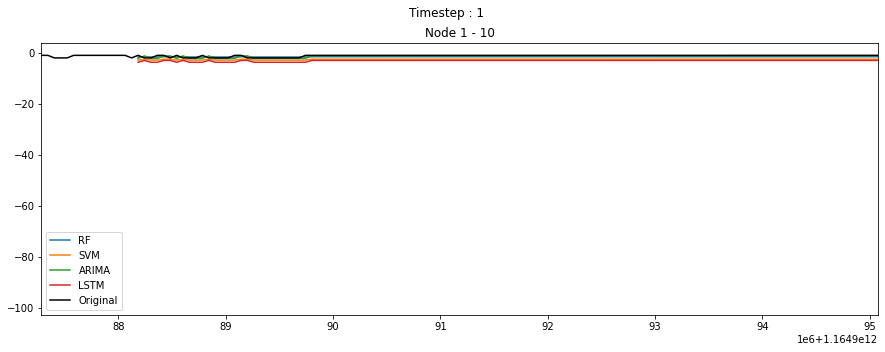

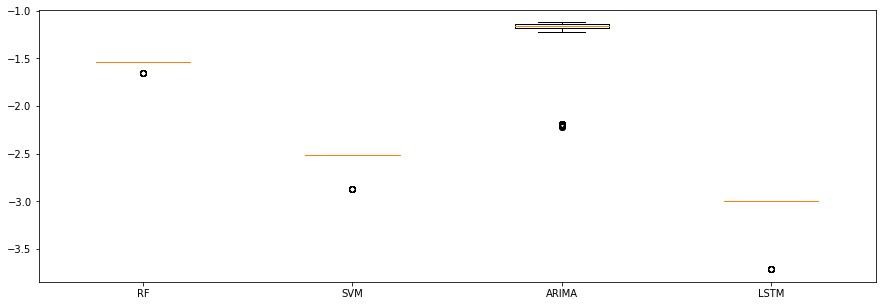

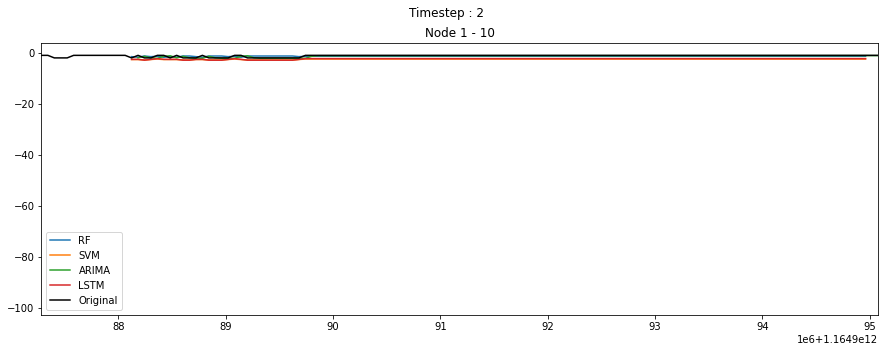

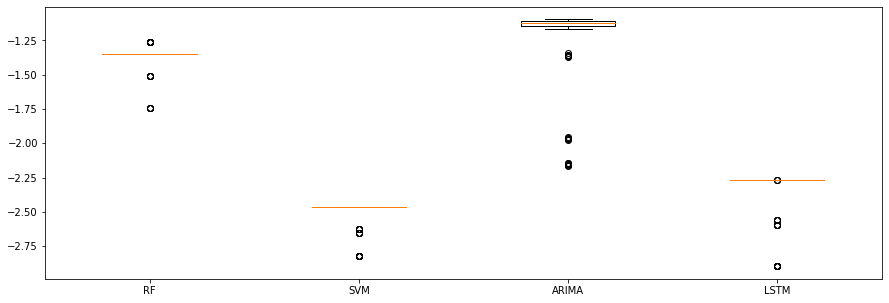

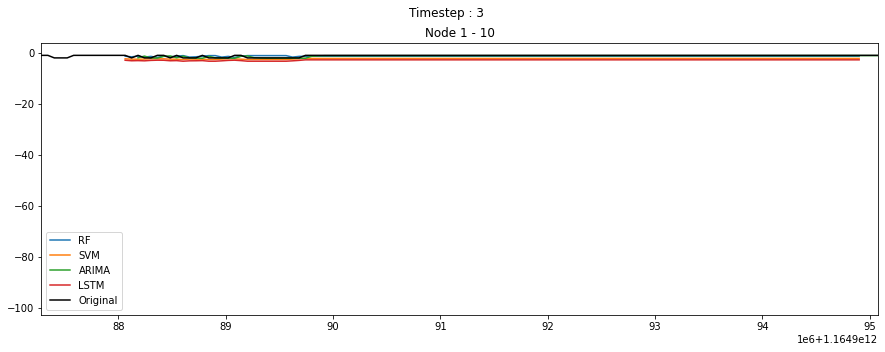

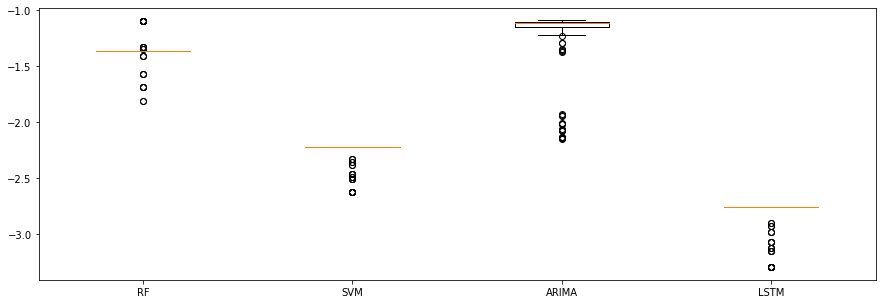

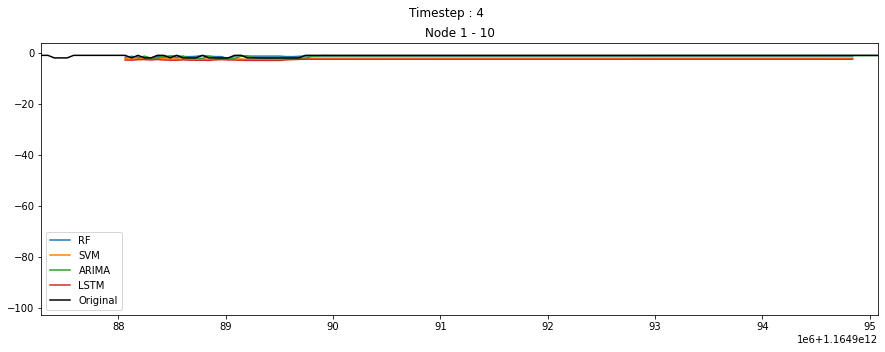

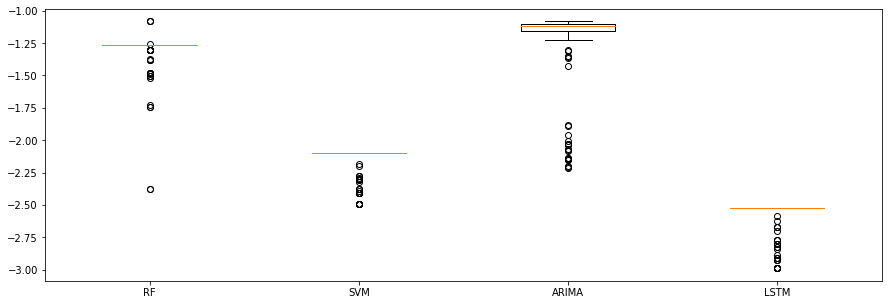

In [33]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataGamma.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 1
epocas = 32
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

ADF Estadistico: -3.994007
Valor p: 0.001442
Valores críticos
	1%: -3.454
	5%: -2.872
	10%: -2.572
-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


({'Errores modelo RF : 1': (0.70934, 0.55699, 65.05838, -4.17899),
  'Errores modelo RF : 2': (1.52426, 0.79947, 84.56989, -10.05173),
  'Errores modelo RF : 3': (0.54099, 0.74977, 69.50105, -2.92246),
  'Errores modelo RF : 4': (0.62846, 0.8342, 75.02199, -3.72657)},
 {'Errores modelo SVR :1': (0.23756, 0.48473, 51.61575, -0.73449),
  'Errores modelo SVR :2': (0.24068, 0.47004, 49.99908, -0.74503),
  'Errores modelo SVR :3': (0.23028, 0.44371, 47.72869, -0.66963),
  'Errores modelo SVR :4': (0.22143, 0.45104, 48.63154, -0.66531)},
 {'Errores modelo ARIMA :1': (0.35147, 0.49373, 47.03599, -1.56616),
  'Errores modelo ARIMA :2': (0.40733, 0.54332, 50.8569, -1.97397),
  'Errores modelo ARIMA :3': (0.3919, 0.52951, 49.73255, -1.86129),
  'Errores modelo ARIMA :4': (0.37082, 0.51077, 48.29108, -1.70743)},
 {'Errores modelo LSTM : 1': (0.61886, 0.79051, 71.61807, -3.51837),
  'Errores modelo LSTM : 2': (0.66524, 0.81562, 73.01421, -3.82333),
  'Errores modelo LSTM : 3': (0.60701, 0.77911, 7

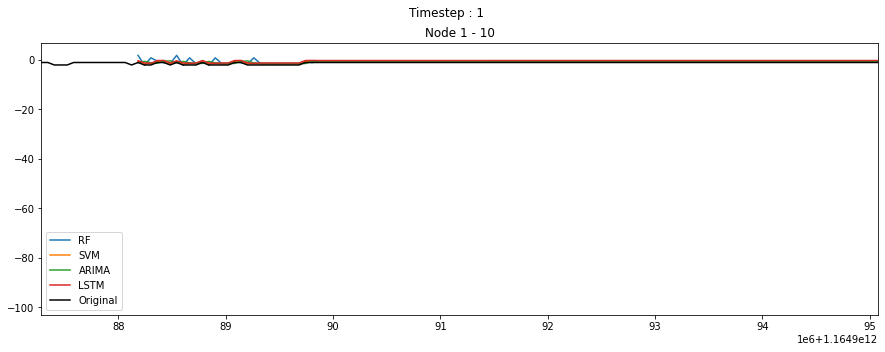

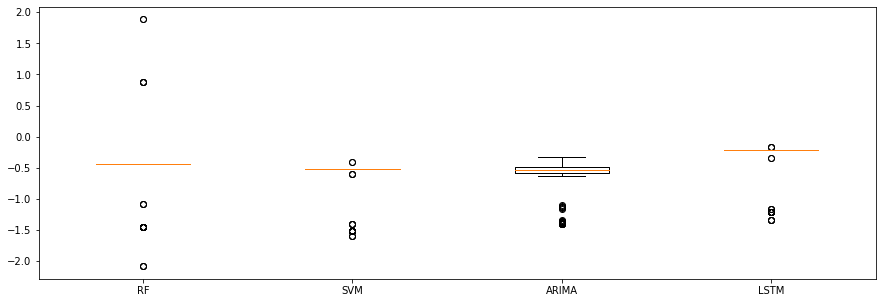

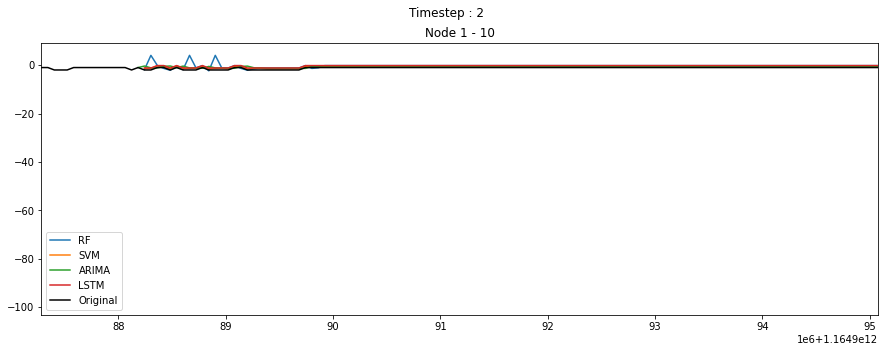

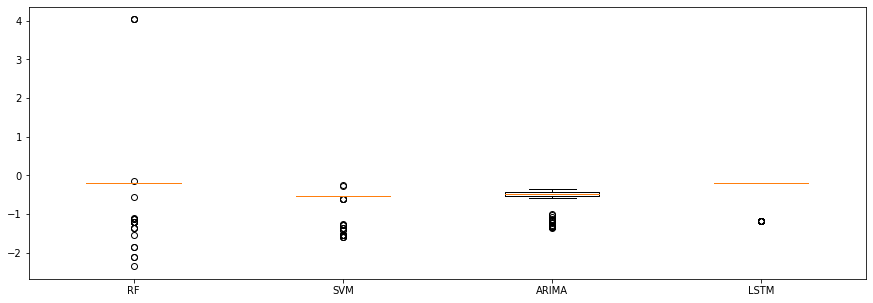

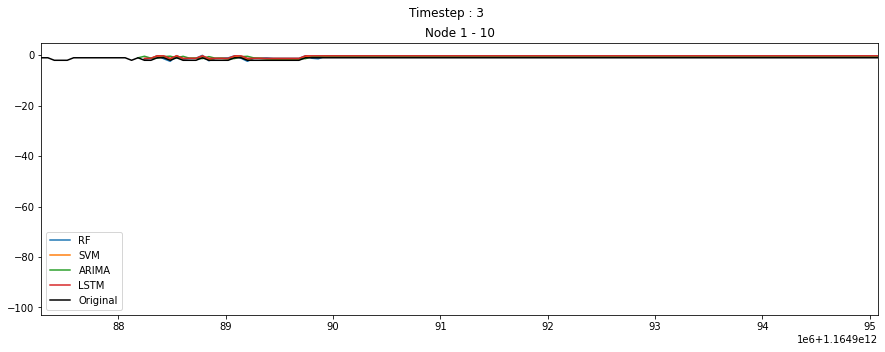

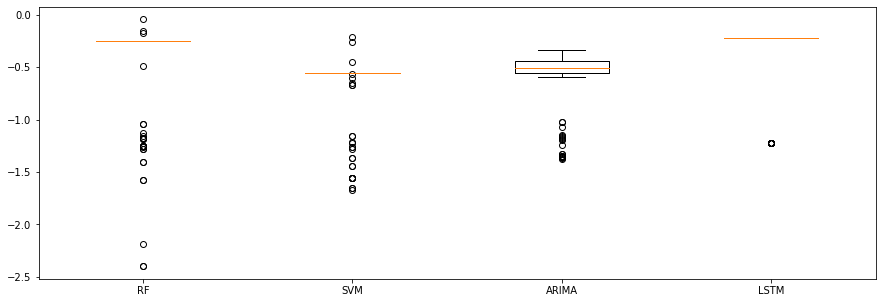

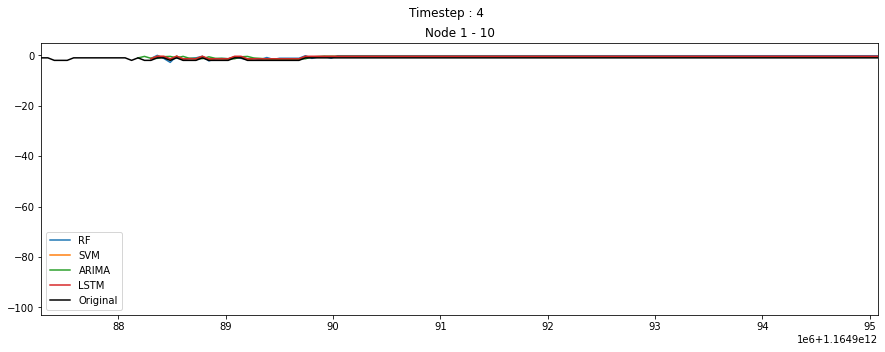

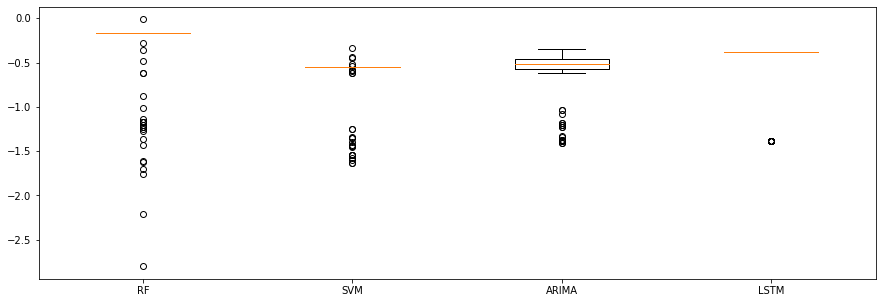

In [34]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

ADF Estadistico: -3.994007
Valor p: 0.001442
Valores críticos
	1%: -3.454
	5%: -2.872
	10%: -2.572
---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------
             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12           6.4
..            ...           ...
284  1.164995e+12           0.5
285  1.164995e+12           0.5
286  1.164995e+12           0.5
287  1.164995e+12           0.5
288  1.164995e+12           0.5

[289 rows x 2 columns]
             Date  SequenceNumber  ...  LqiTransform  RssiTransform
0             NaN             NaN  ...           0.5            NaN
1             NaN             NaN  ...           0.5            NaN
2             NaN             NaN  ...           0.5            NaN
3             NaN             NaN  ...           0.5            NaN
4    1.164978e+12             0.8  ...         -84.6          226.6
..          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12           6.4
..            ...           ...
284  1.164995e+12           0.5
285  1.164995e+12           0.5
286  1.164995e+12           0.5
287  1.164995e+12           0.5
288  1.164995e+12           0.5

[289 rows x 2 columns]
             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12           6.4
..            ...           ...
284  1.164995e+12           0.5
285  1.164995e+12           0.5
286  1.164995e+12           0.5
287  1.164995e+12           0.5
288  1.164995e+12           0.5

[289 rows x 2 columns]
             Date  LqiTransform
0             NaN           0.5
1             NaN           0.5
2             NaN           0.5
3             NaN           0.5
4    1.164978e+12       

({'Errores modelo RF : 1': (0.44131, 0.74141, 70.44717, -2.22206),
  'Errores modelo RF : 2': (0.60125, 0.87463, 78.59035, -3.35942),
  'Errores modelo RF : 3': (0.81718, 1.03101, 89.16208, -4.925),
  'Errores modelo RF : 4': (1.21218, 1.27322, 105.36617, -8.11657)},
 {'Errores modelo SVR :1': (0.14586, 0.39994, 46.84919, -0.06494),
  'Errores modelo SVR :2': (0.15063, 0.3997, 46.93427, -0.09214),
  'Errores modelo SVR :3': (0.14933, 0.39966, 47.06717, -0.08273),
  'Errores modelo SVR :4': (0.16763, 0.42918, 49.09076, -0.26074)},
 {'Errores modelo ARIMA :1': (0.00605, 0.00666, 2.50739, 0.93747),
  'Errores modelo ARIMA :2': (0.40733, 0.54332, 50.8569, -1.97397),
  'Errores modelo ARIMA :3': (0.3919, 0.52951, 49.73255, -1.86129),
  'Errores modelo ARIMA :4': (0.37082, 0.51077, 48.29108, -1.70743)},
 {'Errores modelo LSTM : 1': (0.27342, 0.54559, 56.192, -0.99626),
  'Errores modelo LSTM : 2': (0.59977, 0.77445, 70.37271, -3.34864),
  'Errores modelo LSTM : 3': (0.61952, 0.7871, 71.18432

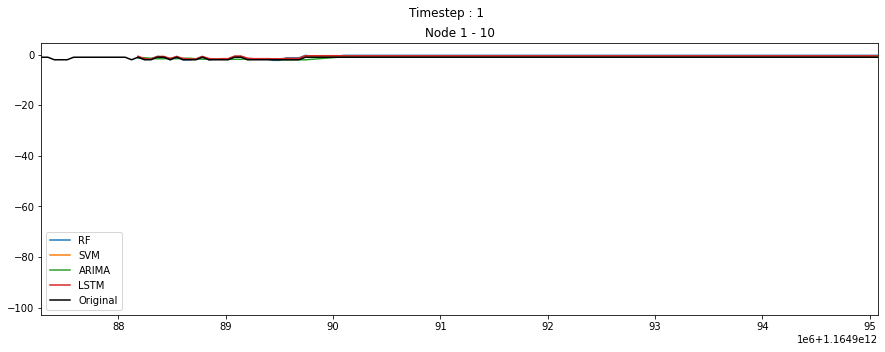

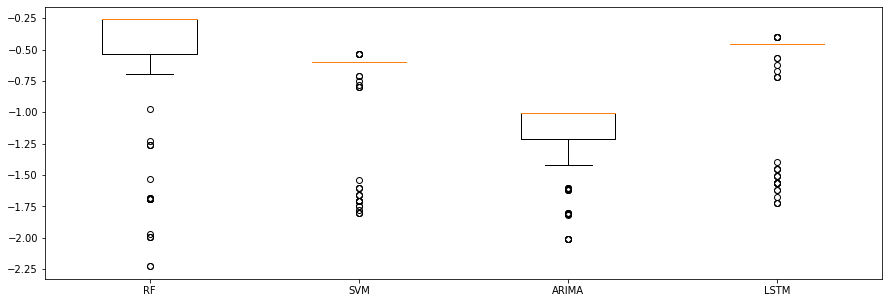

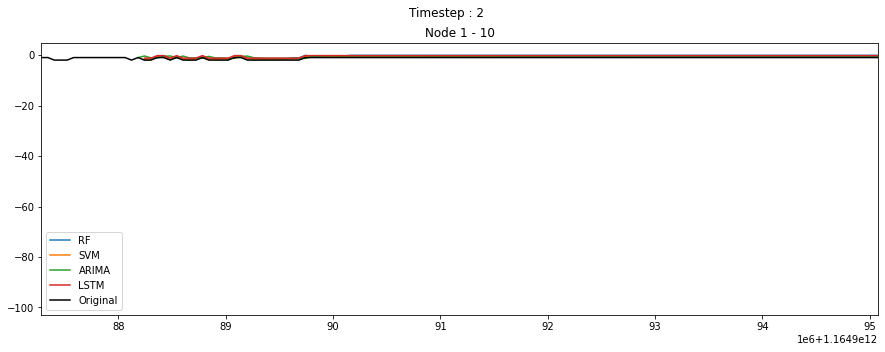

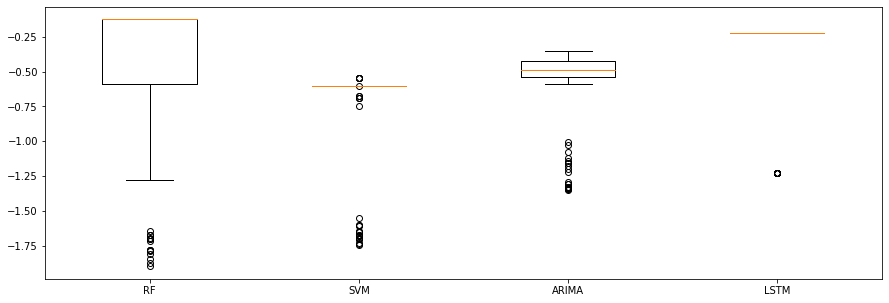

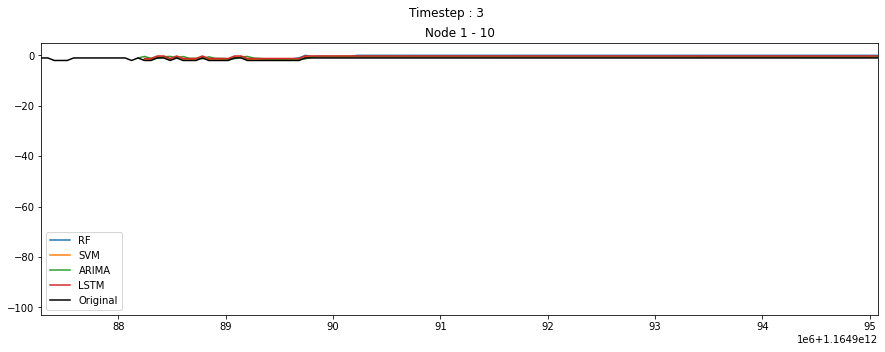

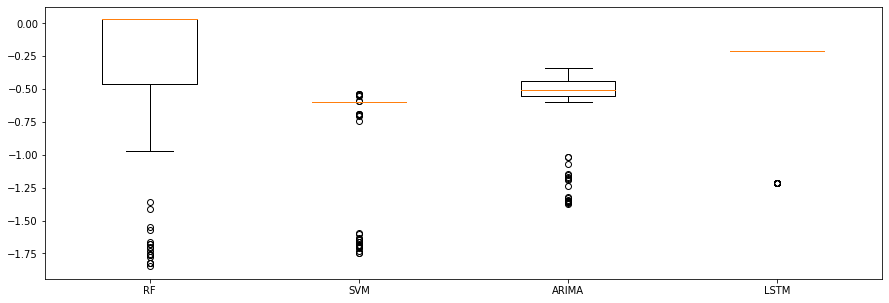

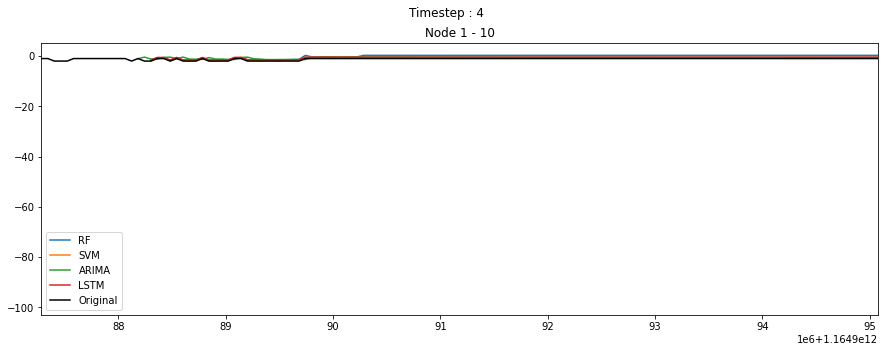

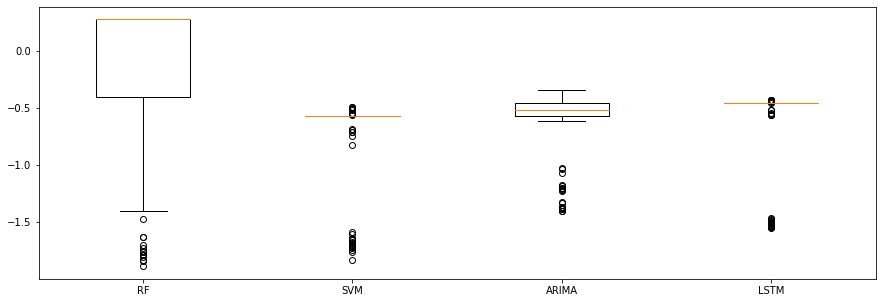

In [35]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

In [36]:
a = np.array([1,2,3,4,5,6])
num = int (len(a) * 0.6)
num


3

In [37]:
b = a[:num]
b

array([1, 2, 3])

In [38]:
c = a [num:]
c

array([4, 5, 6])